In [ ]:
! pip install -U scikit-learn

In [20]:
def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data

def ISLR2data(name, read_csv_args={'index_col':0}):
    import io
    import zipfile
    import os
    import urllib
    
    url = 'https://www.statlearning.com/s/'
    file = 'ALL-CSV-FILES-2nd-Edition-corrected.zip'
    zipdata = urllib.request.urlopen(url+file).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, **read_csv_args)
                return df


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lab: Classification Methods


## The Stock Market Data

We will begin by examining some numerical and graphical summaries of
the `Smarket` data, which is part of the `ISLR2` library. This
data set consists of percentage returns for the S\&P 500 stock index
over $1,250$~days, from the beginning of 2001 until the end of
2005. For each date, we have recorded the percentage returns for each
of the five previous trading days, `lagone` through `lagfive`. We
have also recorded `volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question)  and `direction` (whether the market was `Up` or `Down` on this date). Our goal is to predict `direction` (a qualitative response) using the other features.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 88.0+ KB
None
              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250.000000  1250.000000  1250.000000   
mean   2003.016000     0.003834     0.003919     0.001716     0.001636   
std       1.409018     1.136299     1.136280     1.138703     1.138774   
min    2001.000000    -4.922000    -4.922000    -4.922000    -4.922000   
25%    2002.0000

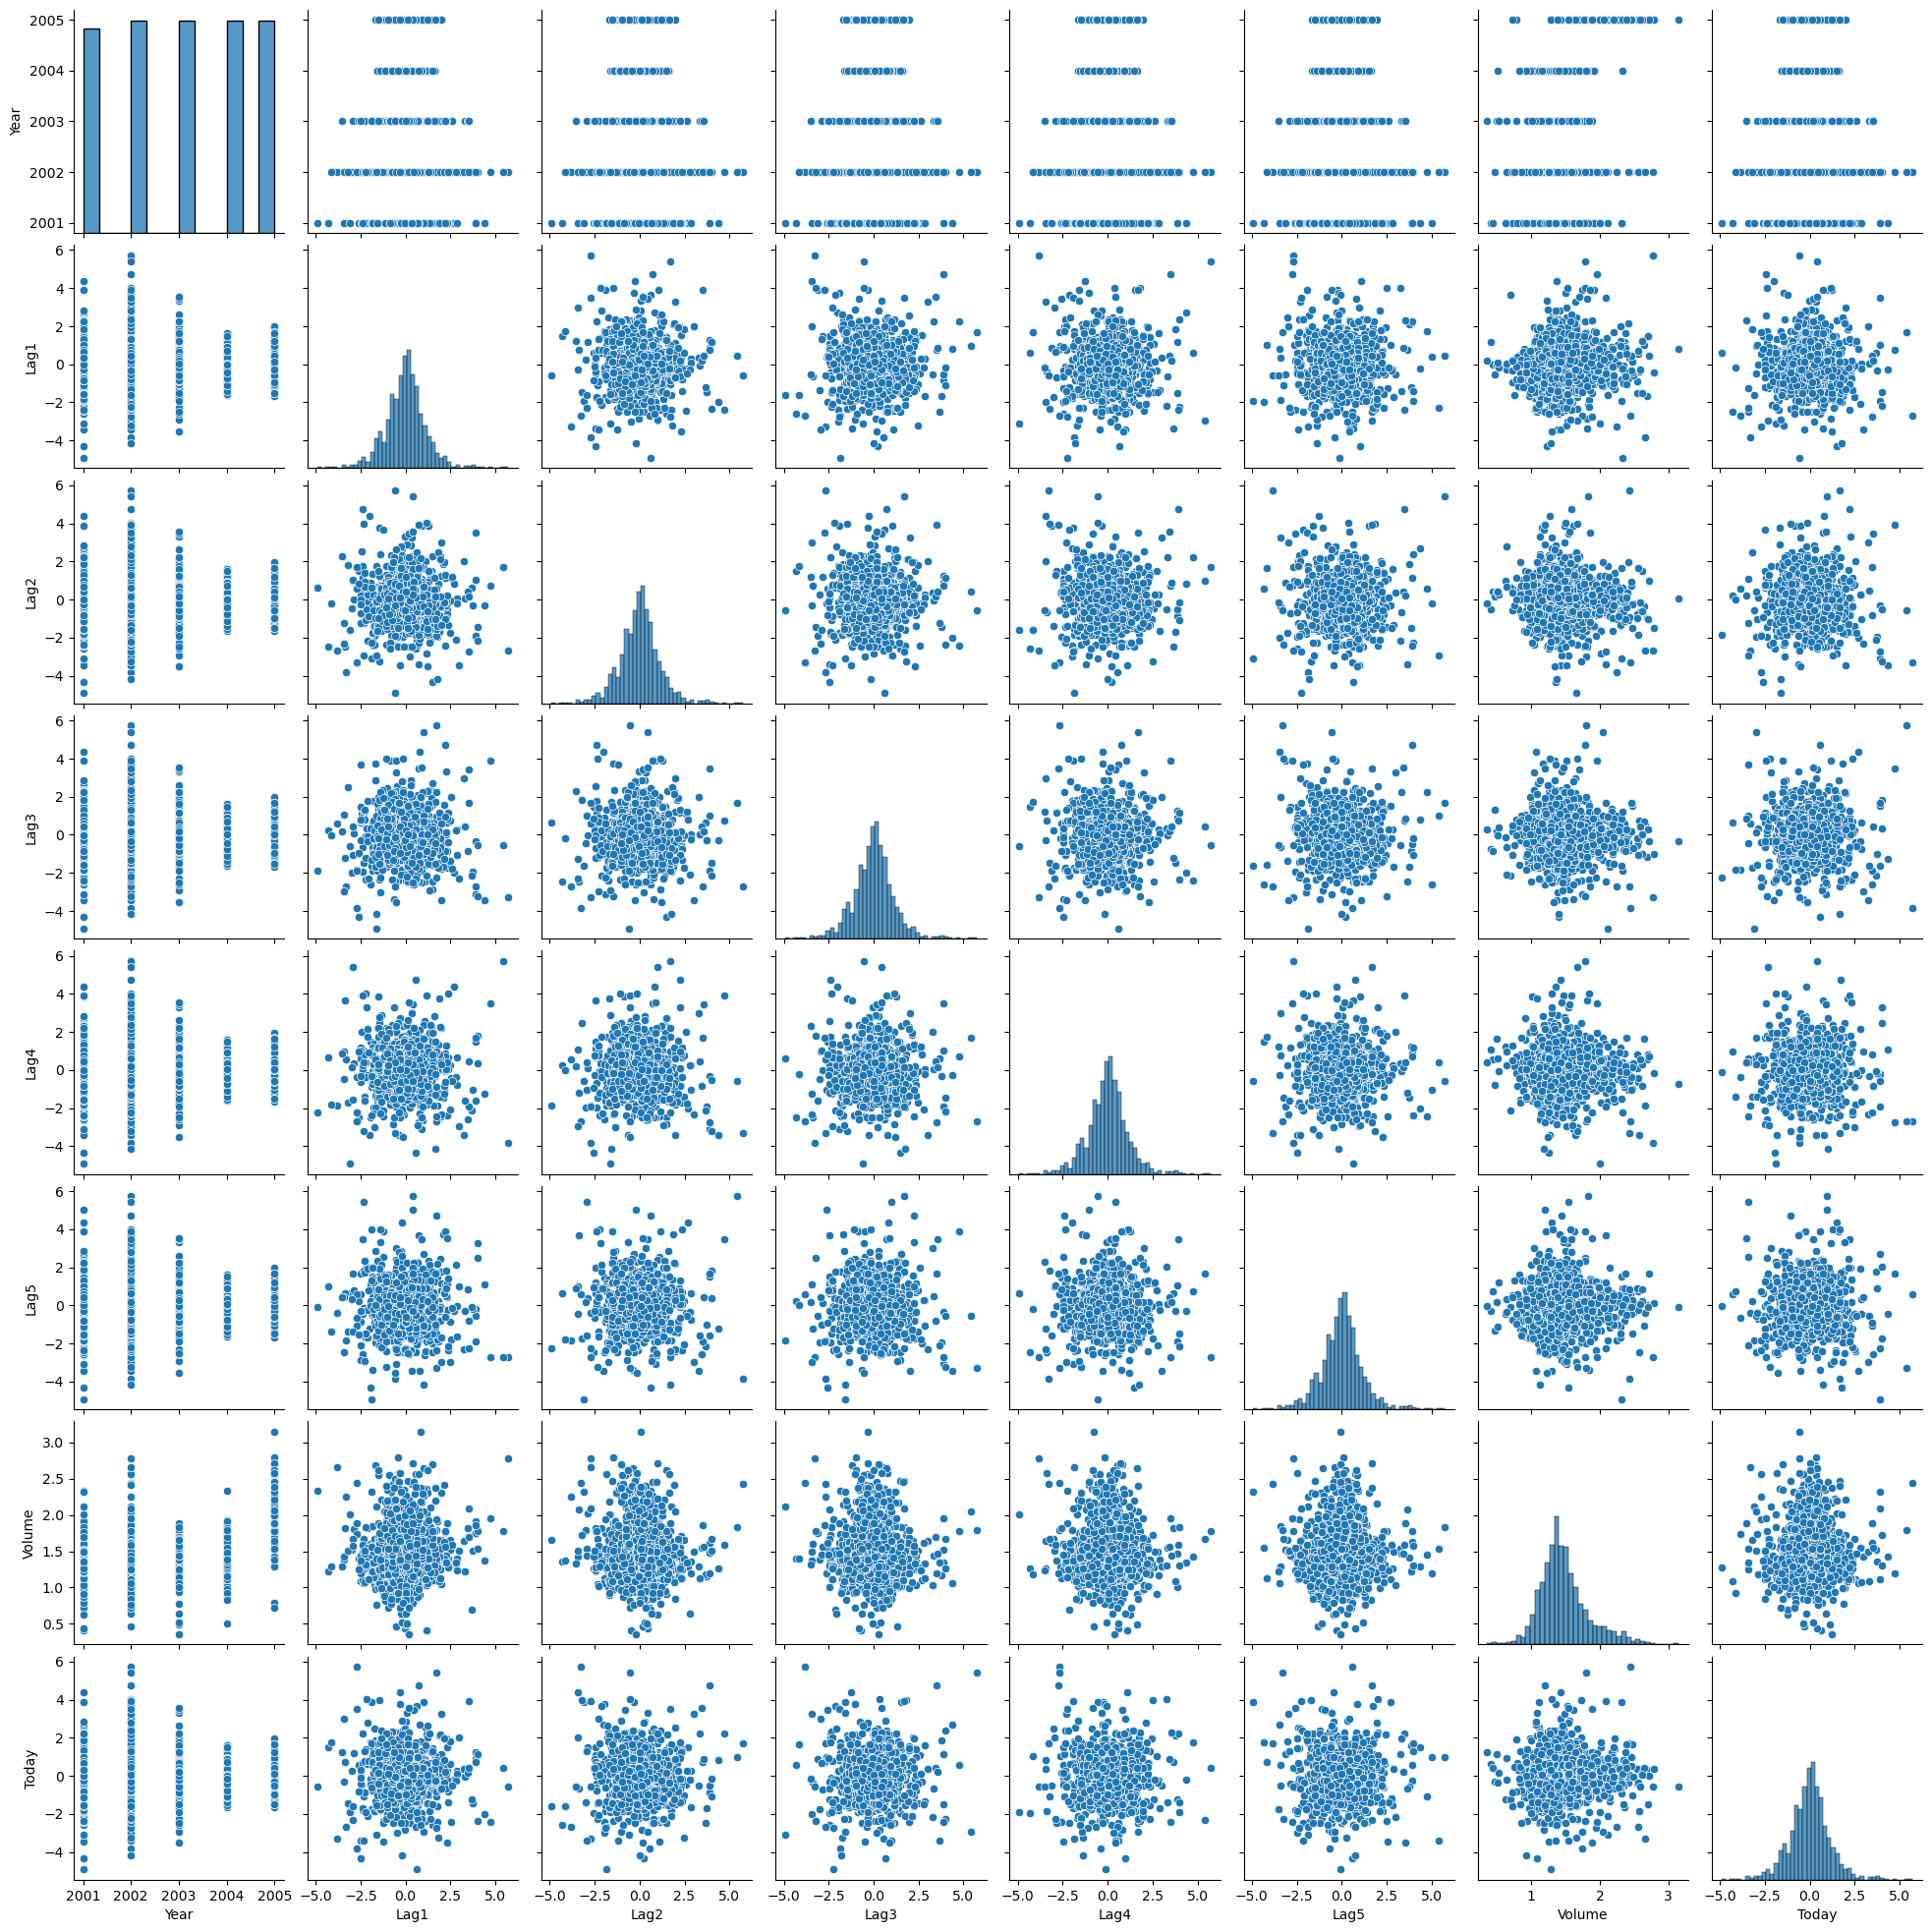

In [22]:
smarket = ISLRdata('Smarket')
print(smarket.info())
print(smarket.describe())
sns.pairplot(smarket)

[1] "Year"      "Lag1"      "Lag2"      "Lag3"      "Lag4"      "Lag5"     
[7] "Volume"    "Today"     "Direction"

[1] 1250    9

      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 

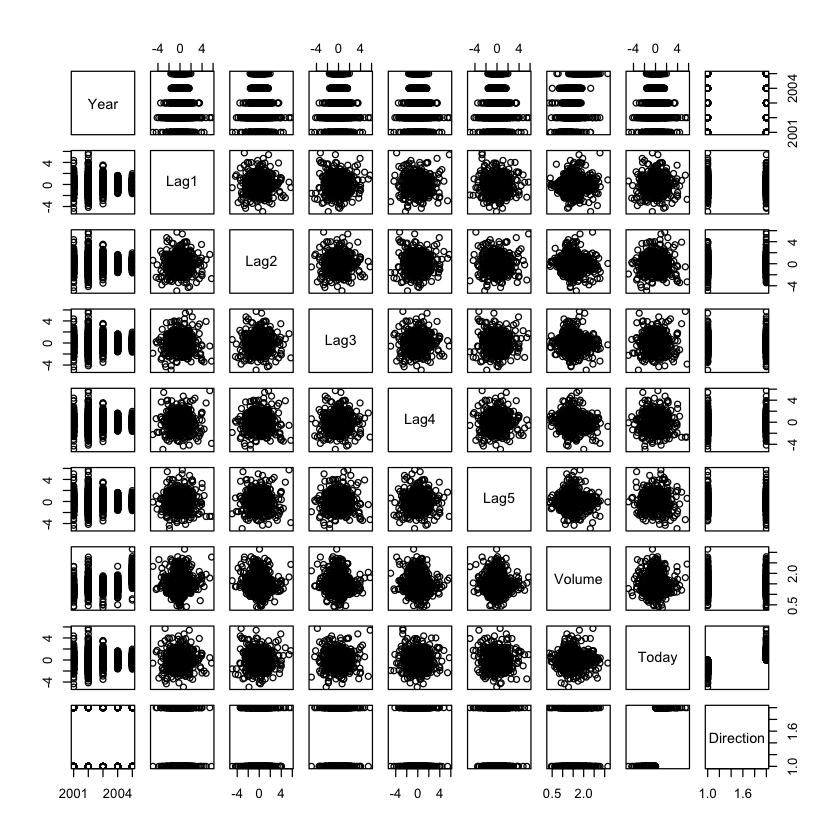

In [1]:
# original R code.
# library(ISLR2)
# names(Smarket)
# dim(Smarket)
# summary(Smarket)
# pairs(Smarket)




The `cor()` function produces a matrix that contains all of the pairwise correlations among the predictors in a data set. The first command below gives an error message because the `direction` variable is qualitative.

In [2]:
# original R code
# cor(Smarket)
# cor(Smarket[, -9])

ERROR: Error in cor(Smarket): 'x' must be numeric


In [4]:
smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lag variables and today's returns are close to zero. In other words, there appears to be little correlation between today's returns and previous days' returns. The only substantial correlation is between `Year` and `volume`. By plotting the data, which is ordered chronologically, we see that `volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

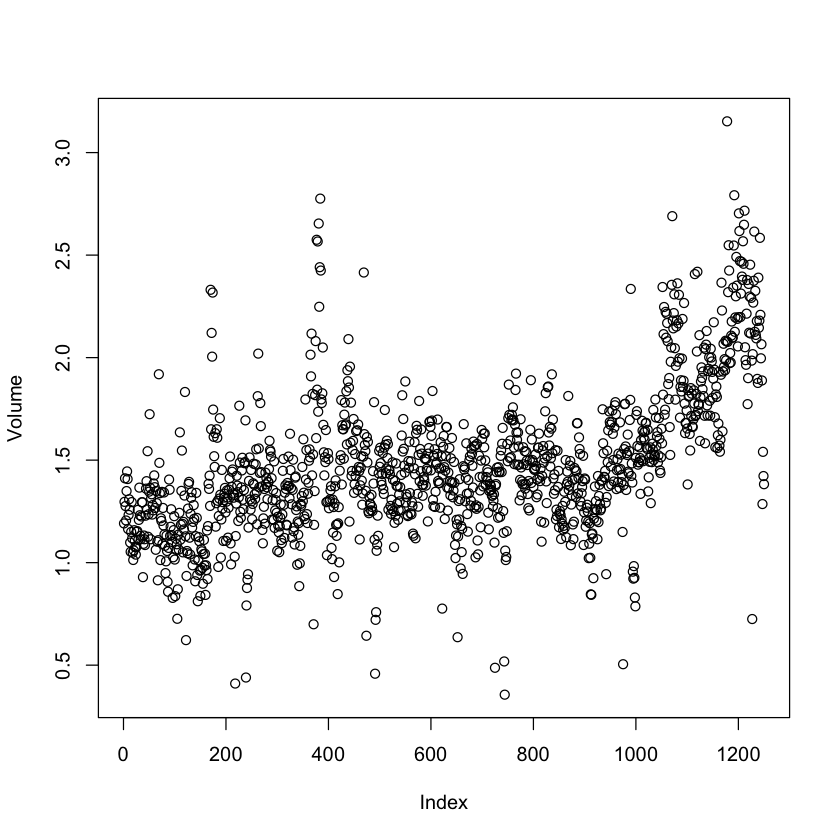

In [3]:
#attach(Smarket)
#plot(Volume)

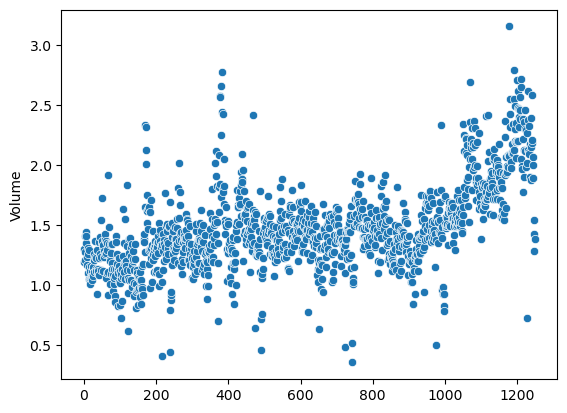

In [23]:
#sns.set_theme()
sns.scatterplot(x=smarket.index, y=smarket.Volume)
#plt.grid()
plt.show()
#sns.__version__

## Logistic Regression

Next, we will fit a logistic regression model in order to predict `direction` using `lagone` through `lagfive` and `volume`. The `glm()` function  can be used to fit many types of generalized linear models , including logistic regression.
 The syntax of the `glm()` function is similar to that of  `lm()`,  except that we must pass in the argument `family = binomial` in order to tell `R` to run a logistic regression rather than some other type of generalized linear model.


In [4]:
# original R code
# glm.fits <- glm(
#     Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
#     data = Smarket, family = binomial
#   )
# summary(glm.fBinomialts)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.446  -1.203   1.065   1.145   1.326  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


In [24]:
import statsmodels.api as sm

glm_fit = sm.GLM.from_formula("Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume",
                              data=smarket, 
                              family=sm.families.Binomial()).fit()
print(glm_fit.summary().as_text())

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1250
Model:                                              GLM   Df Residuals:                     1243
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    Logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -863.79
Date:                                  Fri, 18 Nov 2022   Deviance:                       1727.6
Time:                                          09:26:18   Pearson chi2:                 1.25e+03
No. Iterations:                                       4   Pseudo R-squ. (CS):           0.002868
Covariance Type:                              nonrobust                                         
                 coef    std e

In [25]:
print(smarket.__doc__)

.. container::

   ======= ===============
   Smarket R Documentation
   ======= ===============

   .. rubric:: S&P Stock Market Data
      :name: sp-stock-market-data

   .. rubric:: Description
      :name: description

   Daily percentage returns for the S&P 500 stock index between 2001 and
   2005.

   .. rubric:: Usage
      :name: usage

   ::

      Smarket

   .. rubric:: Format
      :name: format

   A data frame with 1250 observations on the following 9 variables.

   ``Year``
      The year that the observation was recorded

   ``Lag1``
      Percentage return for previous day

   ``Lag2``
      Percentage return for 2 days previous

   ``Lag3``
      Percentage return for 3 days previous

   ``Lag4``
      Percentage return for 4 days previous

   ``Lag5``
      Percentage return for 5 days previous

   ``Volume``
      Volume of shares traded (number of daily shares traded in
      billions)

   ``Today``
      Percentage return for today

   ``Direction``
      A factor

The smallest $p$-value here is associated with `lagone`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of $0.15$, the $p$-value is still relatively large, and so there is no clear evidence of a real association between `lagone` and `direction`. 

 We use the `coef()` function in order to access just the coefficients for this fitted model. We can also use the `summary()` function to access  particular aspects of the fitted model, such as the $p$-values for the coefficients.

In [5]:
# original R code
# coef(glm.fits)
# summary(glm.fits)$coef
# summary(glm.fits)$coef[, 4]

(Intercept)         Lag1         Lag2         Lag3         Lag4         Lag5 
-0.126000257 -0.073073746 -0.042301344  0.011085108  0.009358938  0.010313068 
      Volume 
 0.135440659

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.126000257,0.24073574,-0.5233966,0.6006983
Lag1,-0.073073746,0.05016739,-1.4565986,0.1452272
Lag2,-0.042301344,0.05008605,-0.8445733,0.3983491
Lag3,0.011085108,0.04993854,0.2219750,0.8243333
Lag4,0.009358938,0.04997413,0.1872757,0.8514445
Lag5,0.010313068,0.04951146,0.2082966,0.8349974
Volume,0.135440659,0.15835970,0.8552723,0.3924004


(Intercept)        Lag1        Lag2        Lag3        Lag4        Lag5 
  0.6006983   0.1452272   0.3983491   0.8243333   0.8514445   0.8349974 
     Volume 
  0.3924004

In [16]:
pd.DataFrame({k: getattr(glm_fit, k) for k in 'params pvalues'.split()})

,params,pvalues
Intercept,0.126000,0.600700
Lag1,0.073074,0.145232
Lag2,0.042301,0.398352
Lag3,-0.011085,0.824334
Lag4,-0.009359,0.851445
Lag5,-0.010313,0.834998
Volume,-0.135441,0.392404


The `predict()` function can be used to predict the probability that the market will go up, given values of the predictors. The `type = "response"` option tells `R` to output probabilities of the form $P(Y=1|X)$, as opposed to other information such as the logit. If no data set is supplied to the `predict()` function,
then  the probabilities are computed for the training data that was used to fit the logistic regression model. Here we have printed only the first ten probabilities. We know that these values correspond to the probability of the market going up, rather than down, because the `contrasts()` function indicates that `R` has created a dummy variable with a 1 for `Up`.

In [ ]:
# glm.probs <- predict(glm.fits, type = "response")
# glm.probs[1:10]
# contrasts(Direction)

In [26]:
glm_probs = glm_fit.predict()
glm_probs[:10]

array([0.49291587, 0.51853212, 0.51886117, 0.48477764, 0.48921884,
       0.49304354, 0.50734913, 0.49077084, 0.48238647, 0.51116222])

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, `Up` or `Down`.
The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than $0.5$.

In [27]:
#glm.pred <- rep("Down", 1250)
#glm.pred[glm.probs > .5] = "Up"

The first command creates a vector of 1,250  `Down` elements. The second line transforms to `Up` all of the elements for which the predicted probability of a market increase exceeds $0.5$. Given these predictions, the `table()` function can be used to produce a confusion matrix   in order to determine how many observations were correctly or incorrectly classified. 

In [28]:
glm_pred = np.array(['Up','Down'])[(glm_probs>0.5).astype(int)]
glm_pred[:10]

array(['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down'],
      dtype='<U4')

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [30]:
def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_true, labels=classes), columns=classes, index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


Predicted  Down   Up
True                
Down        145  457
Up          141  507
--------------------------------------------------
accuracy: 0.5216


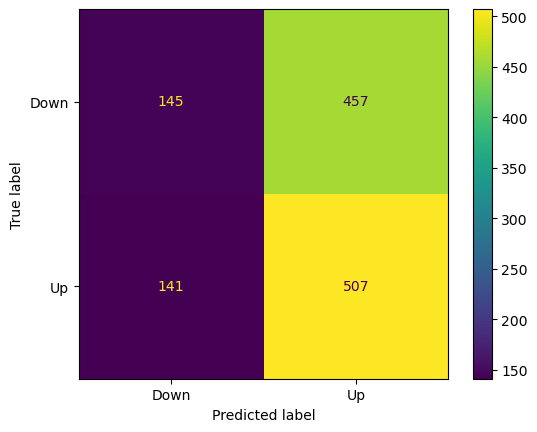

In [31]:
print(cm_(y_pred=glm_pred, y_true=smarket.Direction, classes = 'Down Up'.split()))
print('-'*50)
print('accuracy:', accuracy_score(y_pred=glm_pred, y_true=smarket.Direction))
ConfusionMatrixDisplay.from_predictions(y_pred=glm_pred, y_true=smarket.Direction)


In [9]:
# table(glm.pred, Direction)
# (507 + 145) / 1250
# mean(glm.pred == Direction)

        Direction
glm.pred Down  Up
    Down  145 141
    Up    457 507

[1] 0.5216

[1] 0.5216

The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence our model correctly predicted that the market would go up on $507$ days and that it would go down on $145$ days, for a total of $507+145 = 652$ correct predictions. The `mean()` function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market  $52.2$\,\% of the time.

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the  model on the same set of $1,250$ observations. In other words,
 $100\%-52.2\%=47.8\%$, is the *training* error   rate. As we have seen previously, the training error rate is often overly optimistic---it tends to underestimate the   test error rate.  In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the *held out* data.
This will yield a more realistic error rate, in the sense that in practice we will be interested in our model's performance not on the data that we used to fit the model, but rather on days in the future for which the market's movements are unknown.

To implement this strategy, we will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.

In [10]:
# train <- (Year < 2005)
# Smarket.2005 <- Smarket[!train, ]
# dim(Smarket.2005)
# Direction.2005 <- Direction[!train]

[1] 252   9

In [34]:
train_idx = smarket.Year<2005
train_df = smarket[train_idx]
test_df = smarket[~train_idx]
print(f'length of training data set: {len(train_df)}')
print(f'length of test data set: {len(test_df)}')
                                      

length of training data set: 998
length of test data set: 252


The object `train` is a vector of $1{,}250$ elements, corresponding to the observations in our data set. The elements of the vector that correspond to observations that occurred before 2005 are set to `TRUE`, whereas those that correspond to observations  in 2005 are set to `FALSE`.
The object `train` is a  *Boolean*  vector, since its elements are `TRUE` and `FALSE`.
Boolean vectors can be used to obtain a subset of the rows or columns of a matrix. For instance, the command `Smarket[train, ]` would pick out a submatrix of the stock market data set, corresponding only to the dates before 2005, since
those are the ones for which the elements of `train` are `TRUE`.
The `!` symbol can be used to reverse all of the elements of  a Boolean vector. That is, `!train` is a vector similar to `train`, except that  the elements that are `TRUE` in `train` get swapped to `FALSE` in `!train`, and the elements that are `FALSE`
in `train` get swapped to `TRUE` in `!train`. Therefore, `Smarket[!train, ]` yields a submatrix of the stock market data containing only
the observations for which `train` is `FALSE`---that is, the observations with dates in 2005. The output above indicates that there are 252 such observations.

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005, using the `subset` argument. We then obtain predicted probabilities of the stock market going up for each of the days in our test set---that is, for the days in 2005.

In [11]:
# glm.fits <- glm(
#     Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
#     data = Smarket, family = binomial, subset = train
#   )
# glm.probs <- predict(glm.fits, Smarket.2005,
#     type = "response")

Predicted  Down  Up
True               
Down         77  34
Up           97  44
--------------------------------------------------
Test accuracy: 0.4801587301587302


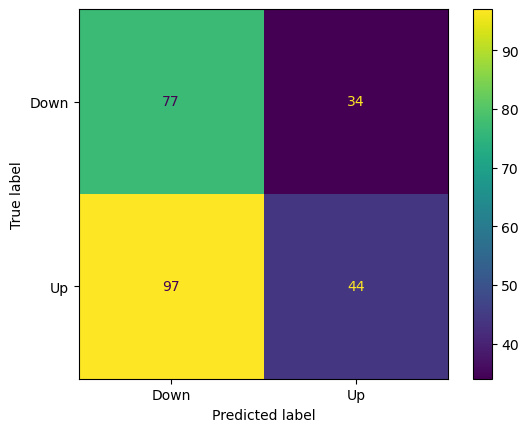

In [35]:
glm_fit = sm.GLM.from_formula("Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume",
                              data=train_df, 
                              family=sm.families.Binomial()).fit()
glm_pred = np.array(['Up','Down'])[(glm_fit.predict(test_df)>0.5).astype(int)]

print(cm_(y_pred=glm_pred, y_true=test_df.Direction))
print('-'*50)
print('Test accuracy:', accuracy_score(y_pred=glm_pred, y_true=test_df.Direction))
ConfusionMatrixDisplay.from_predictions(y_pred=glm_pred, y_true=test_df.Direction)


Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005.
Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [12]:
# glm.pred <- rep("Down", 252)
# glm.pred[glm.probs > .5] <- "Up"
# table(glm.pred, Direction.2005)
# mean(glm.pred == Direction.2005)
# mean(glm.pred != Direction.2005)

        Direction.2005
glm.pred Down Up
    Down   77 97
    Up     34 44

[1] 0.4801587

[1] 0.5198413

The `!=` notation means *not equal to*, and  so the last command computes the  test set error rate. The results are rather disappointing: the test error rate is $52$\,\%, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to  use previous days' returns to predict future market performance. (After all, if it were possible to do so, then the authors of this book would be out striking it rich rather than writing a statistics textbook.)

We recall that the logistic regression model had very underwhelming $p$-values associated with all of the predictors, and that the smallest $p$-value, though not very small, corresponded to `lagone`. Perhaps by removing the variables that appear not  to be helpful in
predicting
`direction`, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement.
 Below we have refit the logistic regression using just `lagone` and `lagtwo`, which seemed to have the highest predictive power in the original logistic regression model.

In [36]:
from sklearn.metrics import classification_report

confusion matrix:
Predicted  Down   Up
True                
Down         35   76
Up           35  106
prediction accuracy: 0.5595238095238095
              precision    recall  f1-score   support

        Down       0.50      0.32      0.39       111
          Up       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



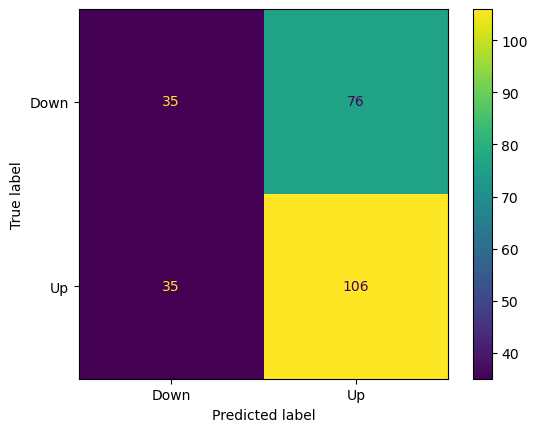

In [37]:
glm_fits = sm.GLM.from_formula("Direction ~ Lag1 + Lag2",
                               data=train_df, 
                               # subset= train_idx, 
                               family=sm.families.Binomial()
                              ).fit()
glm_probs = glm_fits.predict(test_df)
glm_pred = np.array(["Up", "Down"])[(glm_probs>0.5).astype(int)]
print('confusion matrix:', cm_(y_pred=glm_pred, y_true=test_df.Direction), sep='\n')
print('prediction accuracy:', accuracy_score(y_pred=glm_pred, y_true=test_df.Direction))
ConfusionMatrixDisplay.from_predictions(y_pred=glm_pred, y_true=test_df.Direction)

print(classification_report(y_pred=glm_pred, y_true=test_df.Direction))



In [13]:
# glm.fits <- glm(Direction ~ Lag1 + Lag2, data = Smarket,
#     family = binomial, subset = train)
# glm.probs <- predict(glm.fits, Smarket.2005,
#     type = "response")
# glm.pred <- rep("Down", 252)
# glm.pred[glm.probs > .5] <- "Up"
# table(glm.pred, Direction.2005)
# mean(glm.pred == Direction.2005)
# 106 / (106 + 76)

        Direction.2005
glm.pred Down  Up
    Down   35  35
    Up     76 106

[1] 0.5595238

[1] 0.5824176

Now the results appear to be a little better: $56\%$ of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will also be correct $56\%$ of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a $58\%$ accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular values of `lagone` and `lagtwo`. In particular, we want to predict `direction` on a day when `lagone` and `lagtwo` equal 1.2 and 1.1, respectively, and  on a day when they equal  $1.5$ and $-0.8$.
We do this using the `predict()` function.

In [38]:
new_data = pd.DataFrame({"Lag1":[1.2, 1.5], "Lag2":[1.1, -.8]})
print(new_data)
print(pd.DataFrame((glm_fits.model.endog[:10], smarket.Direction[:10])))
glm_fits.predict(new_data)


   Lag1  Lag2
0   1.2   1.1
1   1.5  -0.8
     0    1     2    3    4    5     6    7    8    9
0  0.0  0.0   1.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0
1   Up   Up  Down   Up   Up   Up  Down   Up   Up   Up


0    0.520854
1    0.503906
dtype: float64

In [14]:
# predict(glm.fits,
#     newdata =
#       data.frame(Lag1 = c(1.2, 1.5),  Lag2 = c(1.1, -0.8)),
#     type = "response"
#   )

1         2 
0.4791462 0.4960939

### The same (except the statistical summary) using `scikit-learn`

In [40]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [45]:
smarket0 = pd.get_dummies(smarket)
smarket0

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Down,Direction_Up
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,0,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,0,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,1,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,0,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,0,1
...,...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,0,1
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,1,0
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,0,1
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,1,0


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def Xy(df, predictors=None, response='Direction'):
    X = df.drop(columns=[response]) if predictors is None else df[predictors]
    return X, df[response]

def compute_coef(scaler, estimator, names=None):
    if scaler is not None:
        mean = scaler.mean_
        std = scaler.scale_
        cnames = scaler.get_feature_names_out()
    else:
        mean, std = 0,1
        cnames = (getattr(estimator, 'feature_names_in_', range(estimator.n_features_in_))
                 if names is None else names)
    coef = pd.DataFrame(estimator.coef_/std, columns=cnames)
    coef['Intercept'] = estimator.intercept_ - (estimator.coef_*mean/std).sum()
    return coef

log_reg = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty='none', 
                                           solver='newton-cg', 
                                           #tol=1e-8,
                                           #max_iter=500
                                          ))
#log_reg.fit(*Xy(smarket0, "Lag1 Lag2 Lag3 Lag4 Lag5 Volume".split(), 'Direction_Up'))
log_reg.fit(*Xy(smarket, "Lag1 Lag2 Lag3 Lag4 Lag5 Volume".split()))


print('raw coefs of Logistic Regression')
coef_raw = compute_coef(None, log_reg[-1], log_reg[0].get_feature_names_out())
print(coef_raw[coef_raw.columns.sort_values()].to_string(line_width=80))
print('-'*50)
    
coef = compute_coef(*log_reg)
print('coefs of fused model')
print(coef[coef.columns.sort_values()].to_string(line_width=80))
print('-'*50)

print('comparison with statsmodels')
glm_fit = sm.GLM.from_formula("Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume",
                              data=smarket0, 
                              family=sm.families.Binomial()).fit()
coef_sm = pd.DataFrame(glm_fit.params).T
print(coef_sm[coef_sm.columns.sort_values()].to_string(line_width=80))

raw coefs of Logistic Regression
   Intercept   Lag1      Lag2      Lag3      Lag4     Lag5    Volume
0   0.073869 -0.083 -0.048047  0.012618  0.010653  0.01183  0.048787
--------------------------------------------------
coefs of fused model
   Intercept      Lag1      Lag2      Lag3      Lag4      Lag5    Volume
0     -0.126 -0.073074 -0.042301  0.011085  0.009359  0.010313  0.135441
--------------------------------------------------
comparison with statsmodels
   Intercept      Lag1      Lag2      Lag3      Lag4      Lag5    Volume
0     -0.126 -0.073074 -0.042301  0.011085  0.009359  0.010313  0.135441


In [58]:
train_idx = smarket.Year<2005
train_df = smarket[train_idx]
test_df = smarket[~train_idx]

# train_idx = smarket0.Year<2005
# train_df = smarket0[train_idx]
# test_df = smarket0[~train_idx]
print(f'length of training data set: {len(train_df)}')
print(f'length of test data set: {len(test_df)}')


length of training data set: 998
length of test data set: 252


In [59]:
test_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
998,2005,-0.134,0.008,-0.007,0.715,-0.431,0.7869,-0.812,Down
999,2005,-0.812,-0.134,0.008,-0.007,0.715,1.5108,-1.167,Down
1000,2005,-1.167,-0.812,-0.134,0.008,-0.007,1.7210,-0.363,Down
1001,2005,-0.363,-1.167,-0.812,-0.134,0.008,1.7389,0.351,Up
1002,2005,0.351,-0.363,-1.167,-0.812,-0.134,1.5691,-0.143,Down


In [60]:
log_reg.fit(*Xy(train_df, 'Lag1 Lag2'.split()))

X, y = Xy(test_df, 'Lag1 Lag2'.split())

# log_reg.fit(*Xy(train_df, 'Lag1 Lag2'.split(), 'Direction_Up'))

# X, y = Xy(test_df, 'Lag1 Lag2'.split(), 'Direction_Up')
print(log_reg.predict(X)[:10])

print(log_reg.predict_proba(X)[:10])


['Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up']
[[0.49017254 0.50982746]
 [0.47917626 0.52082374]
 [0.46673656 0.53326344]
 [0.47394267 0.52605733]
 [0.49278972 0.50721028]
 [0.49386116 0.50613884]
 [0.49511099 0.50488901]
 [0.48726973 0.51273027]
 [0.4906968  0.5093032 ]
 [0.48437684 0.51562316]]


Predicted  Down   Up
True                
Down         35   76
Up           35  106
              precision    recall  f1-score   support

        Down       0.50      0.32      0.39       111
          Up       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



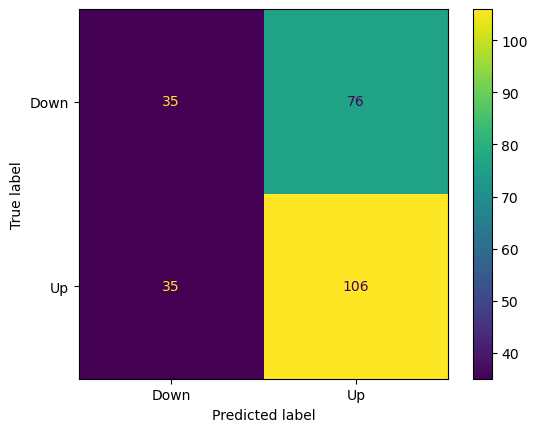

In [61]:
pred = log_reg.predict(X)
print(cm_(y_pred=pred, y_true=y))
print(classification_report(y_pred=pred, y_true=y))
ConfusionMatrixDisplay.from_predictions(y_pred=pred,y_true=y)

## Linear Discriminant Analysis

Now we will perform LDA on the `Smarket` data. In `R`, we fit an LDA model using the  `lda()` function, which is part of the `MASS` library. Notice that the syntax for the `lda()` function is identical to that of `lm()`, and to that of `glm()` except for the absence of the `family` option. We fit the model using only the observations before 2005.

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

def str_LDA(model):
    res = pd.DataFrame(dict(prior=model.priors_), index=model.classes_)
    names = getattr(model , 'feature_names_in_', list(range(model.n_features_in_)))
    res[[n+'_mean' for n in names]] = model.means_
    return res


In [66]:
lda = LDA(store_covariance=True)

lda.fit(*Xy(train_df, "Lag1 Lag2".split()))

print(str_LDA(lda))
print('Covariance matrix')
print(lda.covariance_)
print('-'*20)
print('Coefficients:')
print(compute_coef(None, lda))


         prior  Lag1_mean  Lag2_mean
Down  0.491984   0.042790   0.033894
Up    0.508016  -0.039546  -0.031325
Covariance matrix
[[ 1.50886781 -0.03340234]
 [-0.03340234  1.5095363 ]]
--------------------
Coefficients:
       Lag1      Lag2  Intercept
0 -0.055441 -0.044345   0.032214


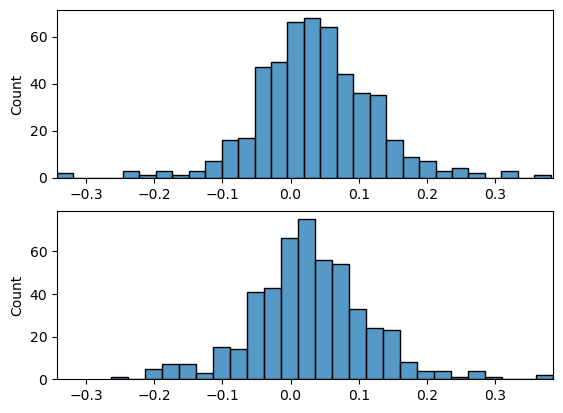

In [67]:


logit = np.dot(X[:10].values, lda.coef_.T)+lda.intercept_

X1, y1 = Xy(train_df, "Lag1 Lag2".split())

delta = lda.decision_function(X1)
idx = y1=='Up'

plt.subplot(2,1,1)
sns.histplot(x=delta[idx])
plt.xlim(delta.min(), delta.max())
plt.subplot(2,1,2)
sns.histplot(x=delta[~idx])
plt.xlim(delta.min(), delta.max())
plt.show()



Attaching package: ‘MASS’


The following object is masked from ‘package:ISLR2’:

    Boston


The following object is masked from ‘package:hastie’:

    enlist




Call:
lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

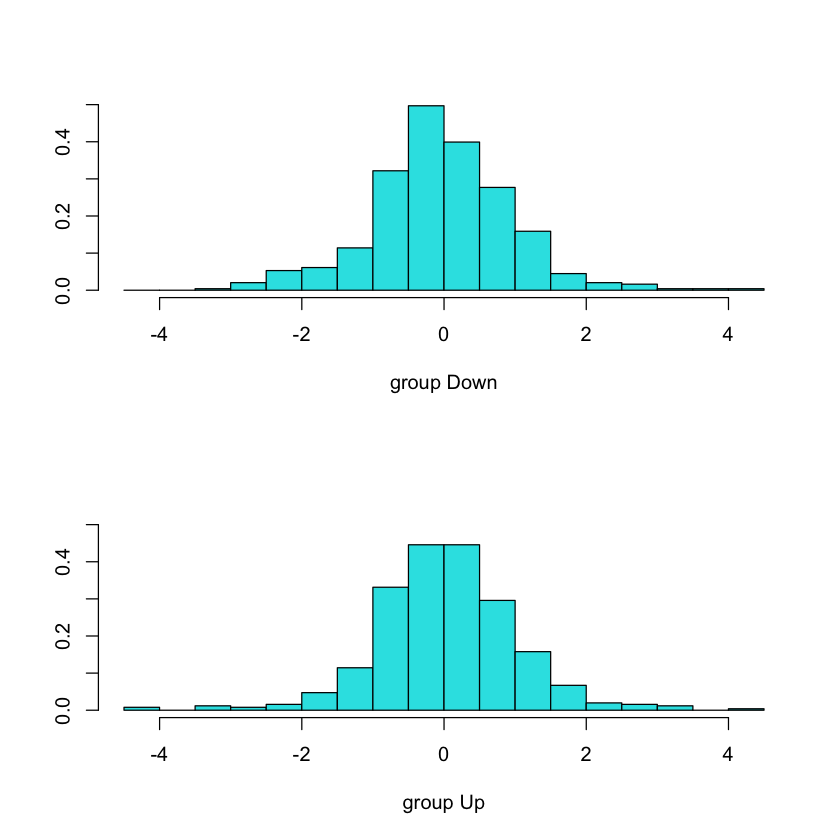

In [15]:
# library(MASS)
# lda.fit <- lda(Direction ~ Lag1 + Lag2, data = Smarket,
#     subset = train)
# lda.fit
# plot(lda.fit)

The LDA output indicates that $\hat\pi_1=0.492$ and $\hat\pi_2=0.508$; in other words, $49.2$\,\% of the training observations correspond to days during which the market went down.
 It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$.
 These suggest that there is a tendency for the previous 2~days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines.
  The *coefficients of linear discriminants* output provides the linear combination of `lagone` and `lagtwo` that are used to form the LDA decision rule. In other words, these are the multipliers of the elements of $X=x$ in ( 4.24).
  If $-0.642\times$ `lagone` $- 0.514 \times $`lagtwo` is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline.

  The `plot()` function produces plots of the *linear discriminants*, obtained by computing $-0.642\times `lagone` - 0.514 \times `lagtwo`$ for each of the training observations. The `Up` and `Down` observations are displayed separately.



The `predict()` function returns a list with three elements. The first element,  `class`,  contains LDA's predictions about the movement of the market. The second element, `posterior`, is a matrix whose $k$th column contains the posterior probability that the corresponding observation belongs to the $k$th class, computed from ( 4.15). Finally, `x` contains the linear discriminants, described earlier.

In [16]:
#lda.pred <- predict(lda.fit, Smarket.2005)
#names(lda.pred)

[1] "class"     "posterior" "x"

As we observed in Section 4.5, the LDA and logistic regression predictions are almost identical.

              precision    recall  f1-score   support

        Down       0.50      0.32      0.39       111
          Up       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



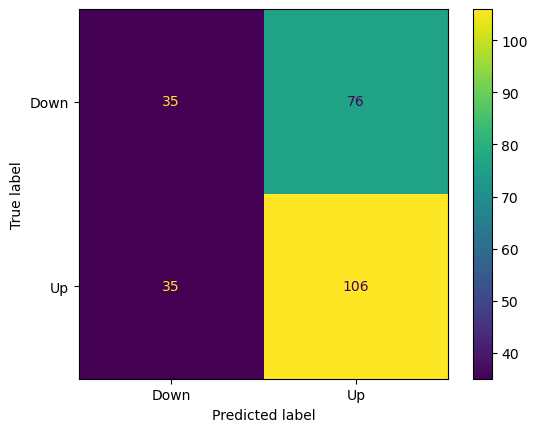

In [68]:
y_pred = lda.predict(X)
print(classification_report(y_pred=y_pred, y_true=y))
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y)
      

In [17]:
#lda.class <- lda.pred$class
#table(lda.class, Direction.2005)
#mean(lda.class == Direction.2005)

         Direction.2005
lda.class Down  Up
     Down   35  35
     Up     76 106

[1] 0.5595238

Applying a $50$\,\% threshold to the posterior probabilities allows us to recreate the predictions contained in `lda.pred$class`.

In [18]:
# sum(lda.pred$posterior[, 1] >= .5)
# sum(lda.pred$posterior[, 1] < .5)

[1] 70

[1] 182

Notice that the posterior probability output by the model corresponds to the probability that the market will *decrease*:

In [19]:
#lda.pred$posterior[1:20, 1]
#lda.class[1:20]

999      1000      1001      1002      1003      1004      1005      1006 
0.4901792 0.4792185 0.4668185 0.4740011 0.4927877 0.4938562 0.4951016 0.4872861 
     1007      1008      1009      1010      1011      1012      1013      1014 
0.4907013 0.4844026 0.4906963 0.5119988 0.4895152 0.4706761 0.4744593 0.4799583 
     1015      1016      1017      1018 
0.4935775 0.5030894 0.4978806 0.4886331

[1] Up   Up   Up   Up   Up   Up   Up   Up   Up   Up   Up   Down Up   Up   Up  
[16] Up   Up   Down Up   Up  
Levels: Down Up

If we wanted to use a posterior probability threshold other than $50$\,\% in order to make predictions, then we could easily do so. For instance, suppose that we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day---say, if the posterior probability
is at least $90$ %.

In [20]:
# sum(lda.pred$posterior[, 1] > .9)

[1] 0

No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was $52.02$ %.

### ROC curve, AUC

ROC curve = Receiver Operating Characteristic curve

AUC = Area Under the Curve

The score function is $\delta$. An observation $x$ is predicted to be positive if $\delta(x)>c$, where $c$ is a threshold.

Each $c\in[-\infty, \infty]$ defines a classification rule.

The False Positive Rate:
$$
\frac{\#\text{false positive cases}}{\#\text{negative cases}}
$$
For $c=-\infty$ it is 1, for $c=+\infty$ it is 0

The True Positive Rate:
$$
\frac{\#\text{true positive cases}}{\#\text{positive cases}}
$$
For $c=-\infty$ it is 1, for $c=+\infty$ it is 0

AUC meaning: Select a positive case $x_1$ and a negative case $x_0$ randomly. 
$$
    \text{AUC}=\mathbb{P}(\delta(x_1)>\delta(x_0))
$$


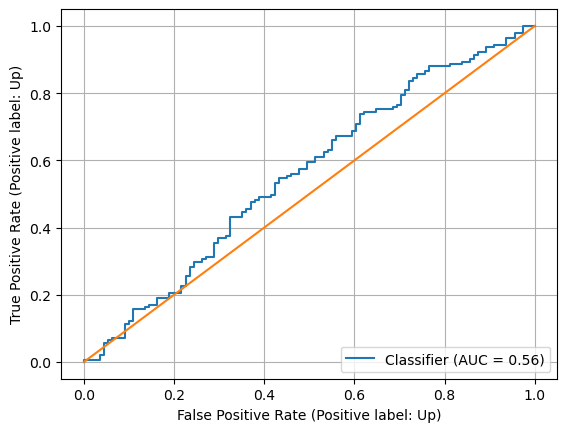

In [75]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_pred=lda.predict_proba(X)[:,1], y_true=y, pos_label='Up')
plt.plot((0,1),(0,1))
plt.grid()
plt.show()



## Quadratic Discriminant Analysis

We will now fit a QDA model to the `Smarket` data. QDA is  implemented in `R` using the `qda()` function, which is also part of the `MASS` library. The syntax is identical to that of `lda()`.

         prior  Lag1_mean  Lag2_mean
Down  0.491984   0.042790   0.033894
Up    0.508016  -0.039546  -0.031325
[[ 1.50662277 -0.03924806]
 [-0.03924806  1.53559498]]
[[ 1.51700576 -0.02787349]
 [-0.02787349  1.49026815]]


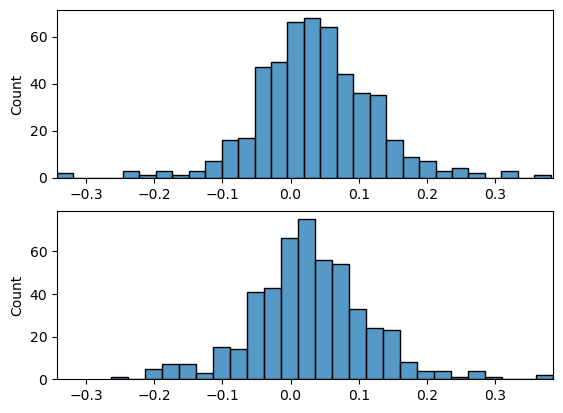

In [70]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

def str_QDA(model):
    res = pd.DataFrame(dict(prior=model.priors_), index=model.classes_)
    names = getattr(model , 'feature_names_in_', list(range(model.n_features_in_)))
    res[[n+'_mean' for n in names]] = model.means_
    return res

qda = QDA(store_covariance=True)

qda.fit(*Xy(train_df, "Lag1 Lag2".split()))

print(str_QDA(qda))
# print(compute_coef(None, qda))
print(*qda.covariance_, sep='\n')

# logit = np.dot(X[:10].values, lda.coef_.T)+lda.intercept_

X1, y1 = Xy(train_df, "Lag1 Lag2".split())

delta = lda.decision_function(X1)
idx = y1=='Up'

plt.subplot(2,1,1)
sns.histplot(x=delta[idx])
plt.xlim(delta.min(),delta.max())
plt.subplot(2,1,2)
sns.histplot(x=delta[~idx])
plt.xlim(delta.min(),delta.max())
plt.show()


In [21]:
# qda.fit <- qda(Direction ~ Lag1 + Lag2, data = Smarket,
#     subset = train)
# qda.fit

Call:
qda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

The output  contains the group means. But it does not contain the coefficients of the linear discriminants, because the QDA classifier involves  a quadratic, rather than a linear, function of the predictors. The `predict()` function works in exactly the same fashion as for LDA.

In [22]:
# qda.class <- predict(qda.fit, Smarket.2005)$class
# table(qda.class, Direction.2005)
# mean(qda.class == Direction.2005)

         Direction.2005
qda.class Down  Up
     Down   30  20
     Up     81 121

[1] 0.5992063

In [71]:
def cm(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y), columns=model.classes_).set_index(model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm

In [72]:
cm(qda,*Xy(test_df,'Lag1 Lag2'.split()))

Predicted,Down,Up
True,,
Down,30,81
Up,20,121


Interestingly, the QDA predictions are accurate almost $60$\,\% of the time, even though the 2005 data was not used  to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite hard to model accurately.
This  suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression.
 However, we recommend evaluating this method's performance on a larger test set  before betting  that this approach will consistently beat the market!

## Naive Bayes

Next, we fit a naive Bayes model to the `Smarket` data. Naive Bayes is implemented in `R` using the `naiveBayes()` function, which is part of the `e1071` library. The syntax is identical to that of `lda()` and `qda()`.
By default, this implementation of the naive Bayes classifier models each quantitative feature using a Gaussian distribution. However, a kernel density method can also be used to estimate the distributions.

In `python` the Gaussian naive Bayes classifier is in the module `sklearn.naive_bayes` under the name `GaussianNB`. Other variants are also available. 

In [73]:
from sklearn.naive_bayes import GaussianNB
nb_fit = GaussianNB().fit(*Xy(train_df,"Lag1 Lag2".split()))

def str_NB(model):
    res = pd.DataFrame(dict(prior=model.class_prior_), index=model.classes_)
    names = getattr(model , 'feature_names_in_', list(range(model.n_features_in_)))
    res[[n+'_mean' for n in names]] = model.theta_
    # res[[n+'_var' for n in names]] = model.var_
    res[[n+'_std' for n in names]] = model.var_**0.5
    # res.set_index(model.classes_)
    return res

print(str_NB(nb_fit))

print()
print('check')

for d in ['Down', 'Up']:
    print('-'*50)
    print(d)
    print(train_df[train_df.Direction==d]["Lag1 Lag2".split()].aggregate(['mean', 'std']))
# nb_fit.classes_
# print(nb_fit.class_prior_, nb_fit.theta_, nb_fit.var_**0.5, sep='\n\n')
                          

         prior  Lag1_mean  Lag2_mean  Lag1_std  Lag2_std
Down  0.491984   0.042790   0.033894  1.226195  1.237929
Up    0.508016  -0.039546  -0.031325  1.230453  1.219561

check
--------------------------------------------------
Down
          Lag1      Lag2
mean  0.042790  0.033894
std   1.227446  1.239191
--------------------------------------------------
Up
          Lag1      Lag2
mean -0.039546 -0.031325
std   1.231668  1.220765


In [23]:
# library(e1071)
# nb.fit <- naiveBayes(Direction ~ Lag1 + Lag2, data = Smarket,
#     subset = train)
# nb.fit


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    Down       Up 
0.491984 0.508016 

Conditional probabilities:
      Lag1
Y             [,1]     [,2]
  Down  0.04279022 1.227446
  Up   -0.03954635 1.231668

      Lag2
Y             [,1]     [,2]
  Down  0.03389409 1.239191
  Up   -0.03132544 1.220765


The output  contains the estimated mean and standard deviation for each variable in each class. For example, the mean for `lagone` is $0.0428$ for 

  `Direction=Down`, and the standard deviation is $1.23$. We can easily verify this:

In [24]:
# mean(Lag1[train][Direction[train] == "Down"])
# sd(Lag1[train][Direction[train] == "Down"])

[1] 0.04279022

[1] 1.227446

The `predict()` function is straightforward.

In [25]:
# nb.class <- predict(nb.fit, Smarket.2005)
# table(nb.class, Direction.2005)
# mean(nb.class == Direction.2005)

        Direction.2005
nb.class Down  Up
    Down   28  20
    Up     83 121

[1] 0.5912698

In [148]:
def cm(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y), columns=model.classes_).set_index(model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm
    # cr = classification_report(y_pred=y_pred, y_true=y)
    # print(cm)
    # print(cr)
    # return (cm, cr)


In [74]:
for model in [lda, qda, nb_fit, log_reg]:
    print(type(model).__name__)
    print(cm(model,*Xy(test_df, 'Lag1 Lag2'.split())))
    print('-'*50)

LinearDiscriminantAnalysis
Predicted  Down   Up
True                
Down         35   76
Up           35  106
--------------------------------------------------
QuadraticDiscriminantAnalysis
Predicted  Down   Up
True                
Down         30   81
Up           20  121
--------------------------------------------------
GaussianNB
Predicted  Down   Up
True                
Down         29   82
Up           20  121
--------------------------------------------------
Pipeline
Predicted  Down   Up
True                
Down         35   76
Up           35  106
--------------------------------------------------


Naive Bayes performs very well on this data, with accurate predictions over $59\%$ of the time. This is slightly worse than QDA, but much better than LDA.

The `predict()` function can also generate estimates of the probability that each observation belongs to a particular class. 

In [26]:
# nb.preds <- predict(nb.fit, Smarket.2005, type = "raw")
# nb.preds[1:5, ]

Down,Up
0.4873164,0.5126836
0.4762492,0.5237508
0.4653377,0.5346623
0.4748652,0.5251348
0.4901890,0.5098110


## $K$-Nearest Neighbors

We will now perform KNN using the `knn()` function, which is part of the `class` library. This function works rather differently from the other model-fitting functions that we have encountered thus far.
Rather than a two-step approach  in which we first fit the model and then we use the model to make predictions, `knn()` forms predictions using a single command. The function requires four inputs.

* A matrix containing the predictors associated with the training data, labeled `train.X` below.
* A matrix containing the predictors associated with the data for which we wish to make predictions, labeled `test.X` below.
* A vector containing the class labels for the training observations, labeled `train.Direction` below.
* A value for $K$, the number of nearest neighbors to be used by the classifier.

We use the `cbind()` function, short for *column bind*, to bind the `lagone` and `lagtwo` variables together into two matrices, one for the training set and the other for the test set.

In [76]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import make_scorer


In [77]:

acc = make_scorer(accuracy_score)

knn = KNN(n_neighbors=1).fit(*Xy(train_df, 'Lag1 Lag2'.split()))
print(cm(knn, *Xy(test_df, 'Lag1 Lag2'.split())))
print('accuracy:', acc(knn, *Xy(test_df, 'Lag1 Lag2'.split())))

Predicted  Down  Up
True               
Down         43  68
Up           58  83
accuracy: 0.5


In [59]:
# np.array(Xy(test_df,'Lag1 Lag2'.split())[0].columns), knn.feature_names_in_, lda.feature_names_in_
# from sklearn.base import _get_feature_names
# _get_feature_names(Xy(test_df,'Lag1 Lag2'.split())[0])
# knn._validate_data??

In [27]:
# library(class)
# train.X <- cbind(Lag1, Lag2)[train, ]
# test.X <- cbind(Lag1, Lag2)[!train, ]
# train.Direction <- Direction[train]

Now the `knn()` function can be used to predict the market's movement for the dates in 2005. We set a random seed before we apply `knn()` because if several observations are tied as nearest neighbors, then `R` will randomly break the tie. Therefore, a seed must be set in order to ensure reproducibility of results.

In [28]:
# set.seed(1)
# knn.pred <- knn(train.X, test.X, train.Direction, k = 1)
# table(knn.pred, Direction.2005)
# (83 + 43) / 252

        Direction.2005
knn.pred Down Up
    Down   43 58
    Up     68 83

[1] 0.5

The results using $K=1$ are not very good,  since only $50$\,\% of the observations are correctly predicted. Of course, it may be that $K=1$ results in  an overly flexible fit to the data. Below, we repeat the analysis using $K=3$.

In [29]:
# knn.pred <- knn(train.X, test.X, train.Direction, k = 3)
# table(knn.pred, Direction.2005)
# mean(knn.pred == Direction.2005)

        Direction.2005
knn.pred Down Up
    Down   48 54
    Up     63 87

[1] 0.5357143

The results have improved slightly. But increasing $K$ further turns out to provide no further improvements. It appears that for this data, QDA provides the best results of the methods that we have examined so far.



## Caravan insurance dataset

KNN does not perform well on the `Smarket` data but it does often provide impressive results. As an example we will apply the KNN approach to the `Insurance` data set, which is part of the `ISLR2` library. This data set includes $85$ predictors that measure
 demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only $6$\,\% of people purchased caravan  insurance.


In [78]:
caravan=ISLRdata('Caravan')
print(caravan.head())
print(caravan.__doc__)
print(caravan.Purchase.value_counts())

   MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       3       7  ...         0        0        0       1        0         0   
1       4       6  ...         0        0        0       1        0         0   
2       4       3  ...         0        0        0       1        0         0   
3       4       5  ...         0        0        0       1        0         0   
4       4       7  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  Purchase  
0       0

In [30]:
# dim(Caravan)
# attach(Caravan)
# summary(Purchase)
# 348 / 5822

[1] 5822   86

No  Yes 
5474  348

[1] 0.05977327

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Variables that are on a large scale will have a much larger effect
 on the *distance* between the observations, and hence
on the KNN classifier, than variables that are on a small scale. For instance, imagine a data set that contains two variables, `salary` and `age` (measured in dollars and years, respectively). As far as KNN is concerned, a difference of 1,000 USD in salary is enormous compared to a difference of $50$ years in age. Consequently, `salary` will drive the KNN classification results, and `age` will have almost no effect. This is contrary to our intuition  that a salary difference of 1,000 USD is quite small compared to an age difference of $50$ years.
Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured `salary` in Japanese yen, or if we measured `age` in minutes, then we'd get quite different classification results from what we get
 if these two variables are measured in dollars and years.

A good way to handle this problem is to  the data so that all variables are given a mean of  zero and  a standard deviation of one. Then all variables will be on a comparable scale. The `scale()` function does just this.
 In standardizing the data, we exclude column $86$, because that is the qualitative `Purchase` variable.

In [31]:
# standardized.X <- scale(Caravan[, -86])
# var(Caravan[, 1])
# var(Caravan[, 2])
# var(standardized.X[, 1])
# var(standardized.X[, 2])

[1] 165.0378

[1] 0.1647078

[1] 1

[1] 1

Now every column of `standardized.X` has a standard deviation of one and a mean of zero.

We now split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations.
We fit  a KNN model on the training data using $K=1$, and evaluate its performance on the test data.%

In [79]:
def Xy1(df):
    return df.drop(columns=['Purchase']), df.Purchase

train_df = caravan[1000:]
test_df = caravan[:1000]
print(test_df.shape)
knn1 = make_pipeline(StandardScaler(), KNN(n_neighbors=1)).fit(*Xy1(train_df))
print(cm(knn1, *Xy1(test_df)))
print(make_scorer(classification_report)(knn1,*Xy1(test_df)))

(1000, 86)
Predicted   No  Yes
True               
No         874   67
Yes         50    9
              precision    recall  f1-score   support

          No       0.95      0.93      0.94       941
         Yes       0.12      0.15      0.13        59

    accuracy                           0.88      1000
   macro avg       0.53      0.54      0.54      1000
weighted avg       0.90      0.88      0.89      1000



In [32]:
# test <- 1:1000
# train.X <- standardized.X[-test, ]
# test.X <- standardized.X[test, ]
# train.Y <- Purchase[-test]
# test.Y <- Purchase[test]
# set.seed(1)
# knn.pred <- knn(train.X, test.X, train.Y, k = 1)
# mean(test.Y != knn.pred)
# mean(test.Y != "No")

[1] 0.118

[1] 0.059

The vector `test` is numeric, with values
from  $1$ through $1,000$. Typing `standardized.X[test, ]` yields the submatrix of the data containing the observations whose indices range from $1$ to $1,000$, whereas typing 

`standardized.X[-test, ]` yields the submatrix containing the observations whose indices do
*not* range from $1$ to $1,000$.
The KNN error rate on the 1,000 test observations is just under $12$\,\%. At first glance, this may appear to be fairly good. However, since only $6$\,\% of customers purchased insurance, we could get the error rate down to $6$\,\% by always predicting `No` regardless of
the values of the predictors!

Suppose that there is some non-trivial cost to trying to sell insurance to a given individual. For instance, perhaps a salesperson must  visit each potential customer.
If the company tries to sell insurance to a random selection of customers, then the success rate will be only $6$\,\%, which may be far too low given the costs involved.
Instead, the company would like to try to sell insurance only to customers who are likely to buy it. So the  overall error rate is not of interest. Instead,  the fraction of individuals that are correctly predicted to buy insurance is of interest.

 It turns out that KNN with $K=1$ does far better than random guessing among the customers that are predicted to buy insurance. Among  $77$ such customers, $9$, or $11.7$\,\%, actually do purchase insurance.
 This is  double the rate that one would obtain from random guessing.

In [33]:
# table(knn.pred, test.Y)
# 9 / (68 + 9)

        test.Y
knn.pred  No Yes
     No  873  50
     Yes  68   9

[1] 0.1168831

Using $K=3$, the success rate increases to $19$\,\%, and with $K=5$ the rate is $26.7$\,\%. This is  over four times the rate that results from random guessing. It appears that KNN is finding some real patterns in a difficult data set!

In [80]:
knn3 = make_pipeline(StandardScaler(), KNN(n_neighbors=3)).fit(*Xy1(train_df))
print(f'{knn3[-1].n_neighbors} nearest neighbors')
print(cm(knn3, *Xy1(test_df)))
print(make_scorer(classification_report)(knn3, *Xy1(test_df)))
print('-'*50)

knn5 = make_pipeline(StandardScaler(), KNN(n_neighbors=5)).fit(*Xy1(train_df))
print(f'{knn5[-1].n_neighbors} nearest neighbors')
print(cm(knn5, *Xy1(test_df)))
print(make_scorer(classification_report)(knn5, *Xy1(test_df)))

3 nearest neighbors
Predicted   No  Yes
True               
No         920   21
Yes         53    6
              precision    recall  f1-score   support

          No       0.95      0.98      0.96       941
         Yes       0.22      0.10      0.14        59

    accuracy                           0.93      1000
   macro avg       0.58      0.54      0.55      1000
weighted avg       0.90      0.93      0.91      1000

--------------------------------------------------
5 nearest neighbors
Predicted   No  Yes
True               
No         931   10
Yes         56    3
              precision    recall  f1-score   support

          No       0.94      0.99      0.97       941
         Yes       0.23      0.05      0.08        59

    accuracy                           0.93      1000
   macro avg       0.59      0.52      0.52      1000
weighted avg       0.90      0.93      0.91      1000



In [34]:
# knn.pred <- knn(train.X, test.X, train.Y, k = 3)
# table(knn.pred, test.Y)
# 5 / 26
# knn.pred <- knn(train.X, test.X, train.Y, k = 5)
# table(knn.pred, test.Y)
# 4 / 15

        test.Y
knn.pred  No Yes
     No  920  54
     Yes  21   5

[1] 0.1923077

        test.Y
knn.pred  No Yes
     No  930  55
     Yes  11   4

[1] 0.2666667

However, while this strategy is cost-effective, it is worth noting that only 15 customers are predicted to purchase insurance using KNN with $K=5$. In practice, the insurance company may wish to expend resources on convincing more than just 15 potential customers to buy insurance.

As a comparison, we can also fit a logistic regression model to the data. If we use $0.5$ as the predicted probability cut-off for the classifier, then we have a problem: only seven of the test observations are predicted to purchase insurance. Even worse, we are wrong about all of these!
 However, we are not required to use a cut-off of  $0.5$. If we instead predict a purchase any time the predicted probability of purchase exceeds  $0.25$, we get much better results: we predict that 33 people will purchase insurance, and
 we are correct for about $33$\,\% of these people. This is  over five times better than random guessing!

In [81]:
glm_caravan = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', solver='newton-cg')).fit(*Xy1(train_df))
cm(glm_caravan, *Xy1(test_df))

Predicted,No,Yes
True,,
No,934,7
Yes,59,0


In [82]:
X1, y1 = Xy1(test_df)
p1 = glm_caravan.predict_proba(X1)
y1_pred = glm_caravan.classes_[1*(p1[:,1]>0.25)]
print('Threshold is 0.25')
print(cm_(y_true=y1, y_pred=y1_pred))

Threshold is 0.25
Predicted   No  Yes
True               
No         919   22
Yes         48   11


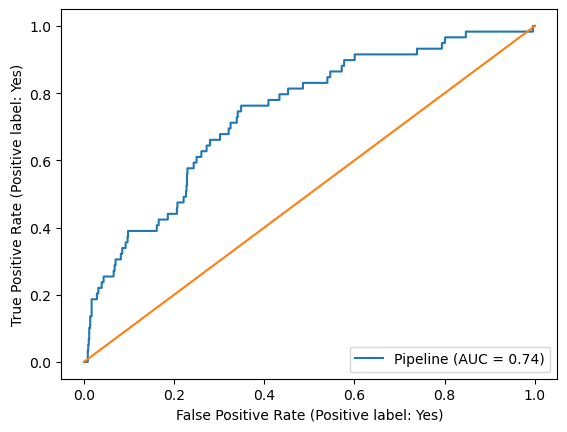

In [83]:
RocCurveDisplay.from_estimator(glm_caravan, *Xy1(test_df))
plt.plot((0,1),(0,1))
plt.show()

In [35]:
# glm.fits <- glm(Purchase ~ ., data = Caravan,
#     family = binomial, subset = -test)
# glm.probs <- predict(glm.fits, Caravan[test, ],
#     type = "response")
# glm.pred <- rep("No", 1000)
# glm.pred[glm.probs > .5] <- "Yes"
# table(glm.pred, test.Y)
# glm.pred <- rep("No", 1000)
# glm.pred[glm.probs > .25] <- "Yes"
# table(glm.pred, test.Y)
# 11 / (22 + 11)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


        test.Y
glm.pred  No Yes
     No  934  59
     Yes   7   0

        test.Y
glm.pred  No Yes
     No  919  48
     Yes  22  11

[1] 0.3333333

## Poisson Regression

Finally, we fit a  Poisson regression model to the `Bikeshare` data set, which measures the number of bike rentals (`bikers`) per hour in Washington, DC. The data can be found in the `ISLR2` library.


In [84]:
bike = ISLR2data('Bikeshare')
print(bike.columns)
bike.head()

Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'bikers'],
      dtype='object')


,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
1,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
2,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
3,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
4,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
5,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


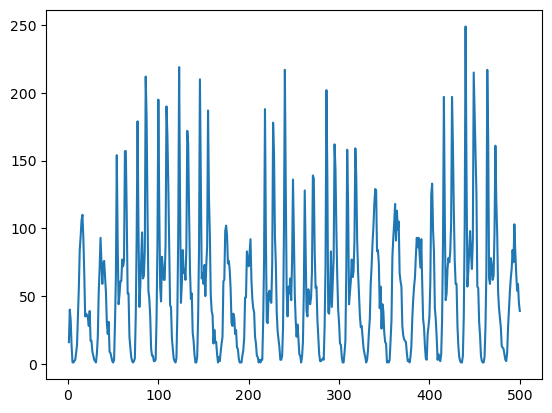

In [107]:
np.unique(bike.season)
bike.groupby('mnth')['hr_c'].count()
# len(bike), 365*24
plt.plot(bike.bikers[:500])

In [36]:
# attach(Bikeshare)
# dim(Bikeshare)
# names(Bikeshare)

[1] 8645   15

[1] "season"     "mnth"       "day"        "hr"         "holiday"   
 [6] "weekday"    "workingday" "weathersit" "temp"       "atemp"     
[11] "hum"        "windspeed"  "casual"     "registered" "bikers"

We begin by fitting a least squares linear regression model to the data.

In [110]:
formula = 'bikers ~ '+ ' + '.join(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'])
formula = 'bikers ~ mnth + hr_c + workingday + temp + weathersit'
print(formula)
bike['hr_c'] = pd.Categorical(bike.hr)
ols_dummy = sm.OLS.from_formula(formula, data=bike).fit() #family=sm.families.Poisson()
ols_dummy.summary()

bikers ~ mnth + hr_c + workingday + temp + weathersit


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:21:57   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -27.2068      6.715     -4.052      0.000     -40.370     -14.044
mnth[T.Aug]                      11.8181      4.698      2.515      0.012       2.609      21.028
mnth[T.Dec]                       5.0328      4.280      1.176      0.240      -3.357      13.423
mnth[T.Feb]                     -34.5797      4.575     -7.558      0.000     -43.548     -25.611
mnth[T.Jan]                     -41.4249      4.972     -8.331      0.000     -51.172     -31.678
mnth[T.July]                      3.8996      5.003      0.779      0.436      -5.907      13.706
mnth[T.June]                     26.3938      4.642      5.686      0.000      17.294      35.493
mnth[T.March]                   -24.8735      4.277     -5.815      0.000     -33.258     -16.489
mnth[T.May]                      31.1322      4.150      7.501      0.000      22.997      39.268
mnth[T.Nov]                      18.8851      4.099      4.607      0.000      10.850      26.920
mnth[T.Oct]                      34.4093      4.006      8.589      0.000      26.556      42.262
mnth[T.Sept]                     25.2534      4.293      5.883      0.000      16.839      33.668
hr_c[T.1]                       -14.5793      5.699     -2.558      0.011     -25.750      -3.408
hr_c[T.2]                       -21.5791      5.733     -3.764      0.000     -32.817     -10.341
hr_c[T.3]                       -31.1408      5.778     -5.389      0.000     -42.468     -19.814
hr_c[T.4]                       -36.9075      5.802     -6.361      0.000     -48.281     -25.534
hr_c[T.5]                       -24.1355      5.737     -4.207      0.000     -35.381     -12.890
hr_c[T.6]                        20.5997      5.704      3.612      0.000       9.419      31.781
hr_c[T.7]                       120.0931      5.693     21.095      0.000     108.934     131.253
hr_c[T.8]                       223.6619      5.690     39.310      0.000     212.509     234.815
hr_c[T.9]                       120.5819      5.693     21.182      0.000     109.423     131.741
hr_c[T.10]                       83.8013      5.705     14.689      0.000      72.618      94.985
hr_c[T.11]                      105.4234      5.722     18.424      0.000      94.207     116.640
hr_c[T.12]                      137.2837      5.740     23.916      0.000     126.032     148.536
hr_c[T.13]                      136.0359      5.760     23.617      0.000     124.745     147.327
hr_c[T.14]                      126.6361      5.776     21.923      0.000     115.313     137.959
hr_c[T.15]                      132.0865      5.780     22.852      0.000     120.756     143.417
hr_c[T.16]                      178.5206      5.772     30.927      0.000     167.206     189.836
hr_c[T.17]                      296.2670     

In [37]:
# mod.lm <- lm(
#     bikers ~ mnth + hr + workingday + temp + weathersit,
#     data = Bikeshare
#   )
# summary(mod.lm)


Call:
lm(formula = bikers ~ mnth + hr + workingday + temp + weathersit, 
    data = Bikeshare)

Residuals:
    Min      1Q  Median      3Q     Max 
-299.00  -45.70   -6.23   41.08  425.29 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -68.632      5.307 -12.932  < 2e-16 ***
mnthFeb                      6.845      4.287   1.597 0.110398    
mnthMarch                   16.551      4.301   3.848 0.000120 ***
mnthApril                   41.425      4.972   8.331  < 2e-16 ***
mnthMay                     72.557      5.641  12.862  < 2e-16 ***
mnthJune                    67.819      6.544  10.364  < 2e-16 ***
mnthJuly                    45.324      7.081   6.401 1.63e-10 ***
mnthAug                     53.243      6.640   8.019 1.21e-15 ***
mnthSept                    66.678      5.925  11.254  < 2e-16 ***
mnthOct                     75.834      4.950  15.319  < 2e-16 ***
mnthNov                     60.310      4.610  13.083  < 2

Due to space constraints, we truncate the output of `summary(mod.lm)`.
In `mod.lm`, the first level of `hr` (0) and `mnth` (Jan) are treated as the baseline values, and so no coefficient estimates are provided for them: implicitly, their coefficient estimates are zero, and all other levels are measured relative to these baselines. For example, the Feb coefficient of $6.845$ signifies that, holding all other variables constant, there are on average about 7 more riders in February than in January. Similarly there are about 16.5 more riders in March than in January.

The results seen in Section 4.6.1 used a slightly different coding of the variables `hr` and `mnth`, as follows:

In [111]:
from patsy.contrasts import Sum

In [112]:
formula1 = 'bikers ~ workingday + temp + weathersit + C(mnth, Sum) + C(hr_c, Sum)' 
print(formula1)
ols_sum = sm.OLS.from_formula(formula1, data=bike).fit()
ols_sum.summary()

bikers ~ workingday + temp + weathersit + C(mnth, Sum) + C(hr_c, Sum)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:22:06   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        73.5974      5.132     14.340      0.000      63.537      83.658
weathersit[T.cloudy/misty]      -12.8903      1.964     -6.562      0.000     -16.741      -9.040
weathersit[T.heavy rain/snow]  -109.7446     76.667     -1.431      0.152    -260.031      40.542
weathersit[T.light rain/snow]   -66.4944      2.965    -22.425      0.000     -72.307     -60.682
C(mnth, Sum)[S.April]            -4.6622      2.741     -1.701      0.089     -10.034       0.710
C(mnth, Sum)[S.Aug]               7.1560      3.535      2.024      0.043       0.227      14.085
C(mnth, Sum)[S.Dec]               0.3706      3.156      0.117      0.907      -5.816       6.558
C(mnth, Sum)[S.Feb]             -39.2419      3.539    -11.088      0.000     -46.179     -32.304
C(mnth, Sum)[S.Jan]             -46.0871      4.085    -11.281      0.000     -54.096     -38.079
C(mnth, Sum)[S.July]             -0.7626      3.908     -0.195      0.845      -8.424       6.899
C(mnth, Sum)[S.June]             21.7317      3.465      6.272      0.000      14.939      28.524
C(mnth, Sum)[S.March]           -29.5357      3.155     -9.361      0.000     -35.721     -23.351
C(mnth, Sum)[S.May]              26.4700      2.851      9.285      0.000      20.882      32.058
C(mnth, Sum)[S.Nov]              14.2229      2.860      4.972      0.000       8.616      19.830
C(mnth, Sum)[S.Oct]              29.7472      2.700     11.019      0.000      24.455      35.039
C(hr_c, Sum)[S.0]               -96.1420      3.955    -24.307      0.000    -103.895     -88.389
C(hr_c, Sum)[S.1]              -110.7213      3.966    -27.916      0.000    -118.496    -102.947
C(hr_c, Sum)[S.2]              -117.7212      4.016    -29.310      0.000    -125.594    -109.848
C(hr_c, Sum)[S.3]              -127.2828      4.081    -31.191      0.000    -135.282    -119.283
C(hr_c, Sum)[S.4]              -133.0495      4.117    -32.319      0.000    -141.119    -124.980
C(hr_c, Sum)[S.5]              -120.2775      4.037    -29.794      0.000    -128.191    -112.364
C(hr_c, Sum)[S.6]               -75.5424      3.992    -18.925      0.000     -83.367     -67.718
C(hr_c, Sum)[S.7]                23.9511      3.969      6.035      0.000      16.172      31.730
C(hr_c, Sum)[S.8]               127.5199      3.950     32.284      0.000     119.777     135.263
C(hr_c, Sum)[S.9]                24.4399      3.936      6.209      0.000      16.724      32.155
C(hr_c, Sum)[S.10]              -12.3407      3.936     -3.135      0.002     -20.056      -4.625
C(hr_c, Sum)[S.11]                9.2814      3.945      2.353      0.019       1.549      17.014
C(hr_c, Sum)[S.12]               41.1417      3.957     10.397      0.000      33.385      48.899
C(hr_c, Sum)[S.13]               39.8939     

In [38]:
# contrasts(Bikeshare$hr) = contr.sum(24)
# contrasts(Bikeshare$mnth) = contr.sum(12)
# mod.lm2 <- lm(
#     bikers ~ mnth + hr + workingday + temp + weathersit,
#     data = Bikeshare
#   )
# summary(mod.lm2)


Call:
lm(formula = bikers ~ mnth + hr + workingday + temp + weathersit, 
    data = Bikeshare)

Residuals:
    Min      1Q  Median      3Q     Max 
-299.00  -45.70   -6.23   41.08  425.29 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 73.5974     5.1322  14.340  < 2e-16 ***
mnth1                      -46.0871     4.0855 -11.281  < 2e-16 ***
mnth2                      -39.2419     3.5391 -11.088  < 2e-16 ***
mnth3                      -29.5357     3.1552  -9.361  < 2e-16 ***
mnth4                       -4.6622     2.7406  -1.701  0.08895 .  
mnth5                       26.4700     2.8508   9.285  < 2e-16 ***
mnth6                       21.7317     3.4651   6.272 3.75e-10 ***
mnth7                       -0.7626     3.9084  -0.195  0.84530    
mnth8                        7.1560     3.5347   2.024  0.04295 *  
mnth9                       20.5912     3.0456   6.761 1.46e-11 ***
mnth10                      29.7472     2.6995 

What is the difference between the two codings?  In `mod.lm2`,  a coefficient estimate is reported for all but the last level of `hr` and `mnth`. Importantly, in `mod.lm2`, the coefficient estimate for the last level of `mnth` is not zero: instead, it equals the *negative of the sum of the coefficient estimates for all of the other levels*. Similarly, in `mod.lm2`, the coefficient estimate for the last level of `hr` is the negative of the sum of the coefficient estimates for all of the other levels. This means that the coefficients of `hr` and `mnth` in `mod.lm2` will always sum to zero, and can be interpreted as the difference from the mean level. For example, the coefficient for January of $-46.087$ indicates that, holding all other variables constant, there are typically 46 fewer riders in January relative to the yearly average.

It is important to realize that the choice of coding really does not matter, provided that we interpret the model output correctly in light of the coding used. For example, we see   that the predictions from the linear model are the same regardless of coding:

In [127]:
np.abs(ols_dummy.predict()-ols_sum.predict()).max()

3.794298208958935e-12

In [39]:
#sum((predict(mod.lm) - predict(mod.lm2))^2)

[1] 1.426274e-18

The sum of squared differences is zero. We can also see this using the `all.equal()` function:

In [40]:
# all.equal(predict(mod.lm), predict(mod.lm2))

[1] TRUE

To reproduce the left-hand side of Figure 4.13, we must first obtain the coefficient estimates associated with `mnth`. The coefficients for January through November can be obtained directly from the `mod.lm2` object. The coefficient for December must be explicitly computed as the negative sum of all the other months.

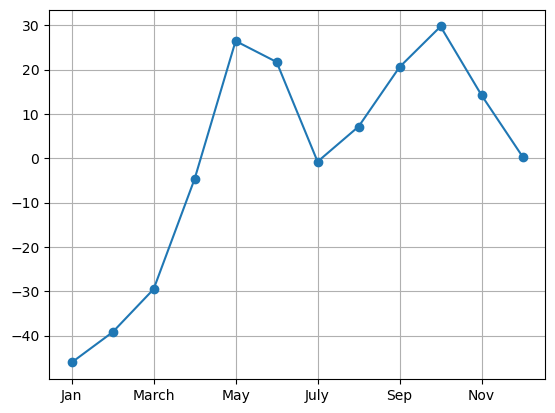

In [113]:
month_coef = {k.split('[S.')[1][:-1]: v for k, v in ols_sum.params.items() if 'mnth' in k}
missing_value = -sum(month_coef.values())
months = 'Jan Feb March April May June July Aug Sep Oct Nov Dec'.split()
month_coef = pd.DataFrame([month_coef.get(m,missing_value) for m in months], columns=['coefficient'], index=months)
month_coef.coefficient.plot( marker='o')
plt.grid()


In [41]:
# coef.months <- c(coef(mod.lm2)[2:12],
#     -sum(coef(mod.lm2)[2:12]))

To make the plot, we manually label the $x$-axis with the names of the months.

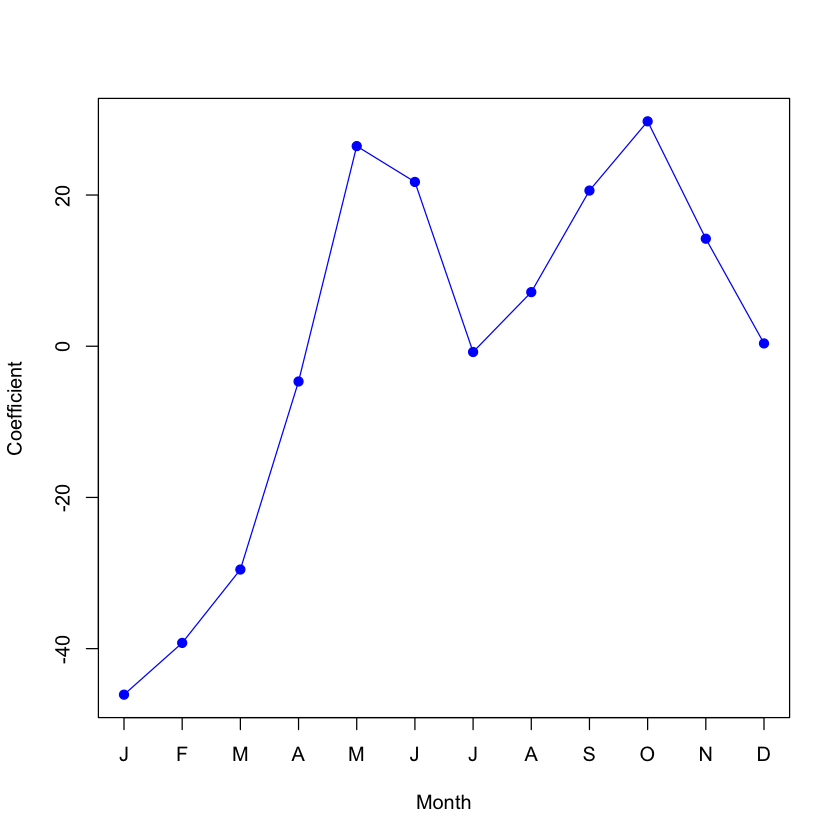

In [42]:
# plot(coef.months, xlab = "Month", ylab = "Coefficient",
#     xaxt = "n", col = "blue", pch = 19, type = "o")
# axis(side = 1, at = 1:12, labels = c("J", "F", "M", "A",
#     "M", "J", "J", "A", "S", "O", "N", "D"))

Reproducing the right-hand side of Figure 4.13 follows a similar process.

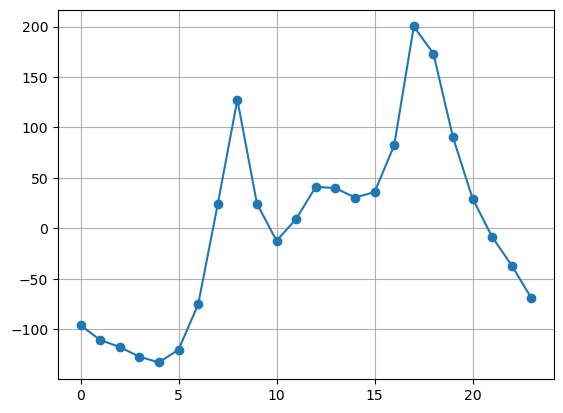

In [114]:
hr_coef = {k.split('[S.')[1][:-1]: v for k, v in ols_sum.params.items() if 'hr_c' in k}
missing_value = -sum(hr_coef.values())
hrs = range(24)
#months = 'Jan Feb March April May June July Aug Sep Oct Nov Dec'.split()
hr_coef = pd.DataFrame([hr_coef.get(str(h), missing_value) for h in hrs], columns=['coefficient'], index=hrs)
hr_coef.coefficient.plot( marker='o')
plt.grid()


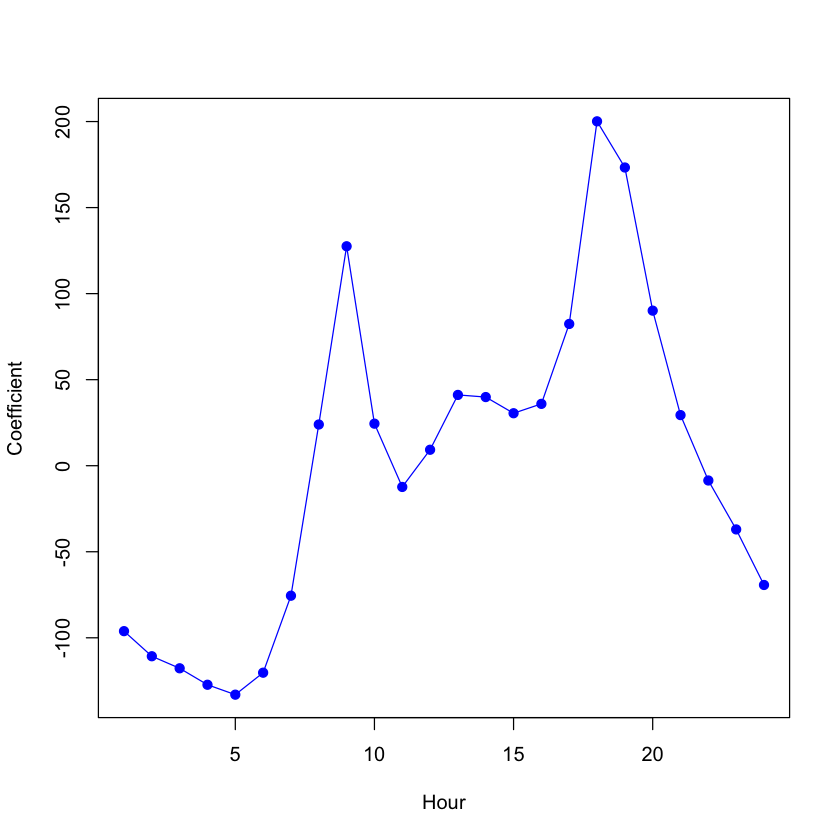

In [43]:
# coef.hours <- c(coef(mod.lm2)[13:35],
#     -sum(coef(mod.lm2)[13:35]))
# plot(coef.hours, xlab = "Hour", ylab = "Coefficient",
#     col = "blue", pch = 19, type = "o")

Now, we consider instead fitting a Poisson regression model to the `Bikeshare` data. Very little changes, except that we now use the function `glm()` with the argument `family = poisson` to specify that we wish to  fit a Poisson regression model:

In [115]:
poisson_fit = sm.GLM.from_formula(formula1, data=bike, family=sm.families.Poisson()).fit()
print(formula1)
poisson_fit.summary()

bikers ~ workingday + temp + weathersit + C(mnth, Sum) + C(hr_c, Sum)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8605
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4054e+05
Date:                Fri, 18 Nov 2022   Deviance:                   2.2804e+05
Time:                        11:22:32   Pearson chi2:                 2.20e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         4.1182      0.006    683.963      0.000       4.106       4.130
weathersit[T.cloudy/misty]       -0.0752      0.002    -34.528      0.000      -0.080      -0.071
weathersit[T.heavy rain/snow]    -0.9263      0.167     -5.554      0.000      -1.253      -0.599
weathersit[T.light rain/snow]    -0.5758      0.004   -141.905      0.000      -0.584      -0.568
C(mnth, Sum)[S.April]             0.0215      0.003      6.888      0.000       0.015       0.028
C(mnth, Sum)[S.Aug]               0.1512      0.004     41.281      0.000       0.144       0.158
C(mnth, Sum)[S.Dec]               0.0167      0.004      4.390      0.000       0.009       0.024
C(mnth, Sum)[S.Feb]              -0.4441      0.005    -91.379      0.000      -0.454      -0.435
C(mnth, Sum)[S.Jan]              -0.6702      0.006   -113.445      0.000      -0.682      -0.659
C(mnth, Sum)[S.July]              0.1036      0.004     25.121      0.000       0.096       0.112
C(mnth, Sum)[S.June]              0.2232      0.004     62.818      0.000       0.216       0.230
C(mnth, Sum)[S.March]            -0.2937      0.004    -70.886      0.000      -0.302      -0.286
C(mnth, Sum)[S.May]               0.2405      0.003     82.462      0.000       0.235       0.246
C(mnth, Sum)[S.Nov]               0.1503      0.003     47.248      0.000       0.144       0.156
C(mnth, Sum)[S.Oct]               0.2676      0.003     96.091      0.000       0.262       0.273
C(hr_c, Sum)[S.0]                -0.7544      0.008    -95.744      0.000      -0.770      -0.739
C(hr_c, Sum)[S.1]                -1.2260      0.010   -123.173      0.000      -1.245      -1.206
C(hr_c, Sum)[S.2]                -1.5631      0.012   -131.702      0.000      -1.586      -1.540
C(hr_c, Sum)[S.3]                -2.1983      0.016   -133.846      0.000      -2.230      -2.166
C(hr_c, Sum)[S.4]                -2.8305      0.023   -125.586      0.000      -2.875      -2.786
C(hr_c, Sum)[S.5]                -1.8147      0.013   -134.775      0.000      -1.841      -1.788
C(hr_c, Sum)[S.6]                -0.4299      0.007    -62.341      0.000      -0.443      -0.416
C(hr_c, Sum)[S.7]                 0.5752      0.004    130.544      0.000       0.567       0.584
C(hr_c, Sum)[S.8]                 1.0769      0.004    302.220      0.000       1.070       1.084
C(hr_c, Sum)[S.9]                 0.5818      0.004    135.727      0.000       0.573       0.590
C(hr_c, Sum)[S.10]                0.3369      0.005     71.372      0.000       0.328       0.346
C(hr_c, Sum)[S.11]                0.4941      0.004    112.494      0.000       0.486       0.503
C(hr_c, Sum)[S.12]                0.6796      0.004    167.040      0.000       0.672       0.688
C(hr_c, Sum)[S.13]                0.6736     

In [44]:
# mod.pois <- glm(
#     bikers ~ mnth + hr + workingday + temp + weathersit,
#     data = Bikeshare, family = poisson
#   )
# summary(mod.pois)


Call:
glm(formula = bikers ~ mnth + hr + workingday + temp + weathersit, 
    family = poisson, data = Bikeshare)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-20.7574   -3.3441   -0.6549    2.6999   21.9628  

Coefficients:
                           Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                4.118245   0.006021  683.964  < 2e-16 ***
mnth1                     -0.670170   0.005907 -113.445  < 2e-16 ***
mnth2                     -0.444124   0.004860  -91.379  < 2e-16 ***
mnth3                     -0.293733   0.004144  -70.886  < 2e-16 ***
mnth4                      0.021523   0.003125    6.888 5.66e-12 ***
mnth5                      0.240471   0.002916   82.462  < 2e-16 ***
mnth6                      0.223235   0.003554   62.818  < 2e-16 ***
mnth7                      0.103617   0.004125   25.121  < 2e-16 ***
mnth8                      0.151171   0.003662   41.281  < 2e-16 ***
mnth9                      0.233493   0.003102   75.281 

We can plot the coefficients associated with `mnth` and `hr`, in order to reproduce Figure 4.15:

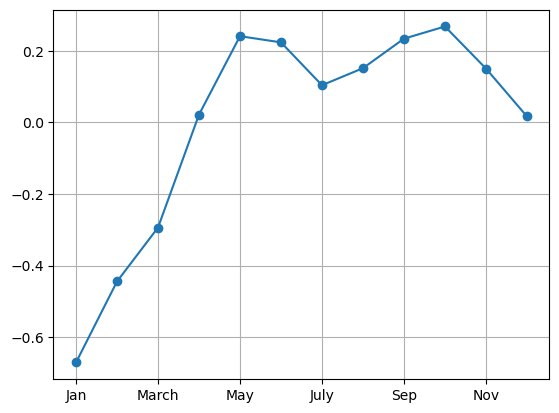

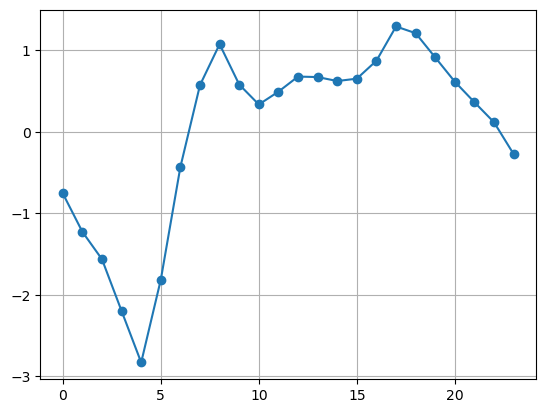

In [116]:
def coeffs(model, key, keys='Jan Feb March April May June July Aug Sep Oct Nov Dec'.split()):
    coef = {k.split('[S.')[1][:-1]: v for k, v in model.params.items() if key in k}
    missing_value = -sum(coef.values())
    # months = 'Jan Feb March April May June July Aug Sep Oct Nov Dec'.split()
    return pd.DataFrame([coef.get(str(k),missing_value) for k in keys], columns=['coefficient'], index=keys)

coeffs(poisson_fit, 'mnth').coefficient.plot( marker='o')
plt.grid()
plt.show()

coeffs(poisson_fit, 'hr_c', keys=range(24)).coefficient.plot( marker='o')
plt.grid()
plt.show()


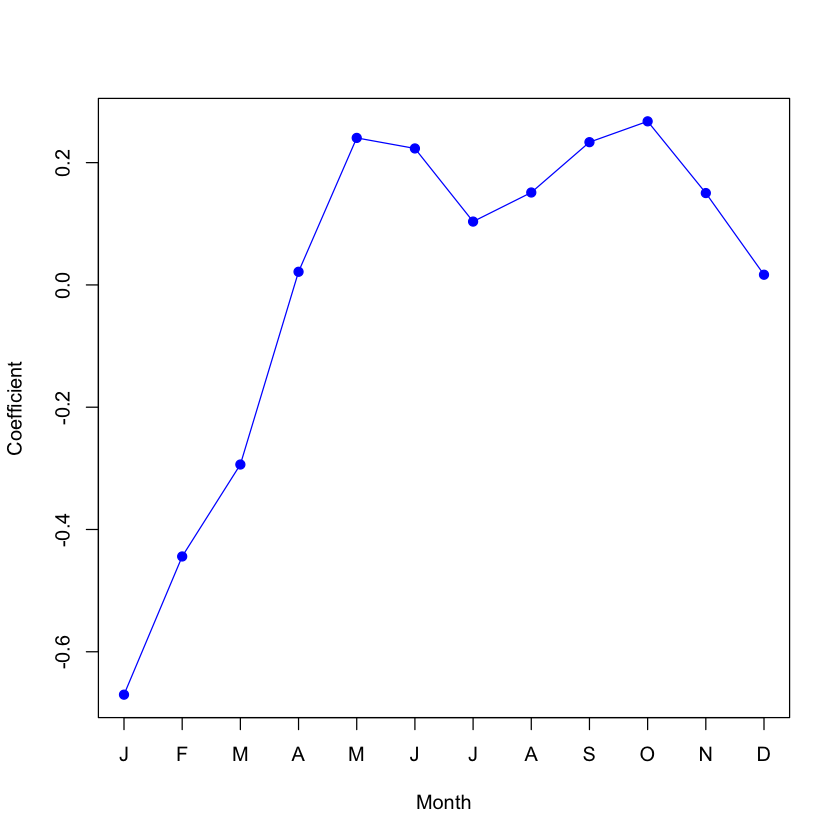

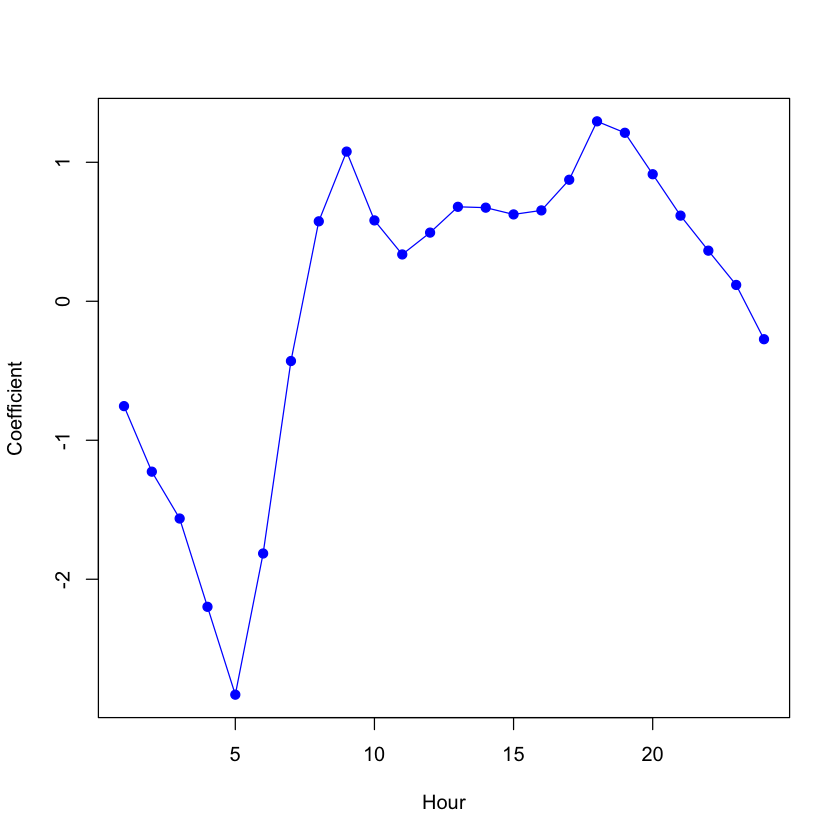

In [45]:
# coef.mnth <- c(coef(mod.pois)[2:12],
#     -sum(coef(mod.pois)[2:12]))
# plot(coef.mnth, xlab = "Month", ylab = "Coefficient",
#      xaxt = "n", col = "blue", pch = 19, type = "o")
# axis(side = 1, at = 1:12, labels = c("J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"))
# coef.hours <- c(coef(mod.pois)[13:35],
#      -sum(coef(mod.pois)[13:35]))
# plot(coef.hours, xlab = "Hour", ylab = "Coefficient",
#     col = "blue", pch = 19, type = "o")

We can once again use the `predict()` function to obtain the fitted values (predictions) from this Poisson regression model. However, we must use the argument `type = "response"` to specify that we want `R` to output $\exp(\hat\beta_0 + \hat\beta_1 X_1 + \ldots +\hat\beta_p X_p)$ rather than $\hat\beta_0 + \hat\beta_1 X_1 + \ldots + \hat\beta_p X_p$, which it will output by default.

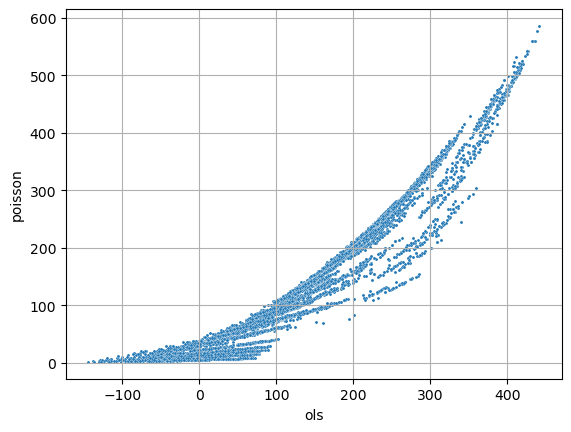

In [117]:
plot_data = pd.DataFrame(dict(ols=ols_sum.predict(), poisson=poisson_fit.predict()))
sns.scatterplot(x='ols', y='poisson', data=plot_data, s=5)
plt.grid()

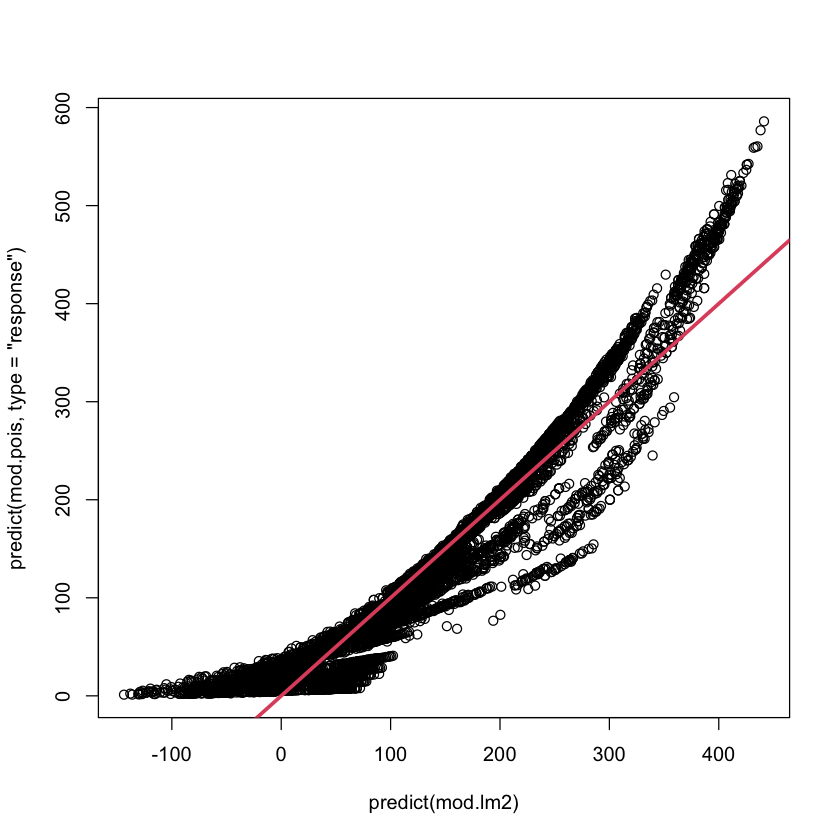

In [46]:
# plot(predict(mod.lm2), predict(mod.pois, type = "response"))
# abline(0, 1, col = 2, lwd = 3)

The predictions from the Poisson regression model are correlated with those from the linear model; however, the former are non-negative. As a result the Poisson regression predictions tend to be larger than those from the linear model for either very low or very high levels of ridership.

In this section, we used the `glm()` function with the argument `family = poisson` in order to perform Poisson regression. Earlier in this lab we used the `glm()` function with `family = binomial` to perform logistic regression. Other choices for the `family` argument can be used to fit other types of GLMs. For instance, `family = Gamma` fits a gamma regression model.



### Poisson regression with  `sklearn`

In [118]:
from sklearn.linear_model import PoissonRegressor

In [119]:
print(formula)
print(bike.columns)

bikers ~ mnth + hr_c + workingday + temp + weathersit
Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'bikers', 'hr_c'],
      dtype='object')


In [120]:
X = bike.drop(columns=['season', 'day', 'holiday', 'weekday', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'bikers', 'hr'])
y = bike.bikers
X = pd.get_dummies(X, drop_first=True)
X.columns

Index(['workingday', 'temp', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan',
       'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_Nov',
       'mnth_Oct', 'mnth_Sept', 'weathersit_cloudy/misty',
       'weathersit_heavy rain/snow', 'weathersit_light rain/snow', 'hr_c_1',
       'hr_c_2', 'hr_c_3', 'hr_c_4', 'hr_c_5', 'hr_c_6', 'hr_c_7', 'hr_c_8',
       'hr_c_9', 'hr_c_10', 'hr_c_11', 'hr_c_12', 'hr_c_13', 'hr_c_14',
       'hr_c_15', 'hr_c_16', 'hr_c_17', 'hr_c_18', 'hr_c_19', 'hr_c_20',
       'hr_c_21', 'hr_c_22', 'hr_c_23'],
      dtype='object')

In [124]:
pois = make_pipeline(StandardScaler(), 
                     PoissonRegressor(alpha=0, tol=1e-8, max_iter=2000))
pois.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('poissonregressor',
                 PoissonRegressor(alpha=0, max_iter=2000, tol=1e-08))])

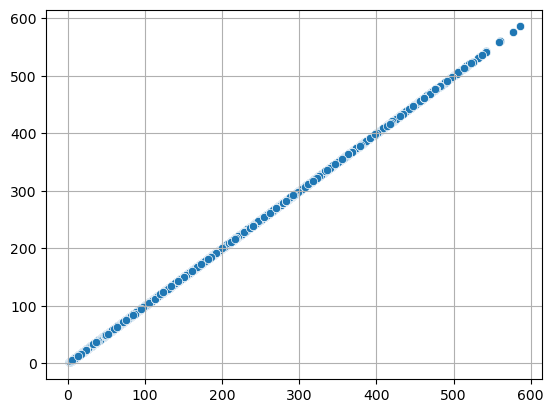

In [122]:
sns.scatterplot(x=poisson_fit.predict(), y=pois.predict(X))
plt.grid()
plt.show()

In [210]:
##PoissonRegressor?